In [ ]:
##################### Following code is for preprocessing "Cargo_Description" column to remove 
#any NST 2007 codes or HS code: and preprocessid files are saved in perticlur path 

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text):
    """
    Preprocesses a single text string.
    """
    if pd.isna(text):  # Handle missing values
        return text
    
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenization
    tokens = word_tokenize(text)
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 6. Reconstruct cleaned text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Create a sample DataFrame


# Apply preprocessing to the 'Text' column
df_original1234["Cargo_Description"] = df_original1234["Cargo_Description"].apply(preprocess_text)

# Display the updated DataFrame
df_original1234

In [ ]:
################ CATBOOT #################################

In [6]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import glob
import os
import joblib
from scipy.sparse import vstack  # Import vstack for proper matrix concatenation

# Function to preprocess data
def fill(val):
    return '0'*(3-len(str(val))) + str(val)

def preprocess_data(df):
    df.rename(columns={'Broken_Packages_Quantity': 'Departure_Packages_Quantity', 
                       'NST2007_3P': 'NST2007'}, inplace=True)
    df = df.drop(columns=["Harmonized_Code", "CN2007_8P_Label_EN", 'NST2007_3P_Label_EN', 
                          'NST2007_2P', 'NST2007_2P_Label_EN'], axis=1)
    df.rename(columns={'Cargo_Description': 'Descrição_Carga'}, inplace=True)
    df['NST2007'] = df['NST2007'].apply(fill)
    
    no_desc = df[df["NST2007"] == "000"].index
    df = df.drop(index=no_desc, axis=1)
    
    df = df.dropna().drop_duplicates().reset_index(drop=True)
    return df

# File paths
train_files = [r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx",
               r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx"]
test_file = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx"

# Load datasets
dfs = [preprocess_data(pd.read_csv(file, encoding="UTF-8", delimiter=",", on_bad_lines="skip")) for file in train_files + [test_file]]
df = pd.concat(dfs, ignore_index=True)

# Convert Movement_Date to datetime
df["Movement_Date"] = pd.to_datetime(df["Movement_Date"])

# Define column types
text_column = "Descrição_Carga"
categorical_columns = ["Container_Plate", "Message", "Embarkation_Port", "Disembarkation_Port",
                        "Transhipment", "ISO_contentainer", "ISO_contentainer_Registry",
                        "Container_State", "Weight", "Departure_Weight"]
numeric_columns = ["Container_Tare", "Departure_Packages_Quantity", "Packages_Quantity"]
target_column = "NST2007"

# **Chunked TF-IDF Processing**
def chunked_tfidf(df, chunk_size=50000):
    tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    chunks = []
    
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        text_data = chunk[text_column].astype(str).fillna('')
        chunk_features = tfidf.fit_transform(text_data)
        chunks.append(chunk_features)
    
    return vstack(chunks)  # ✅ Use vstack instead of hstack for row-wise stacking

text_features = chunked_tfidf(df)

# Scale numerical features
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Merge all features efficiently (Sparse Matrix)
# Convert categorical columns to string before sparse conversion
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import csr_matrix, hstack

# Ensure categorical columns are strings
df[categorical_columns] = df[categorical_columns].astype(str)

# Fill missing values
df[categorical_columns + numeric_columns] = df[categorical_columns + numeric_columns].fillna("missing")

# Convert categorical columns to numerical values (without one-hot encoding explosion)
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.int32)
df[categorical_columns] = encoder.fit_transform(df[categorical_columns])

# Convert numeric columns to float
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Ensure categorical columns are strings
df[categorical_columns] = df[categorical_columns].astype(str)

# Fill missing values
df[categorical_columns + numeric_columns] = df[categorical_columns + numeric_columns].fillna("missing")

# Convert numeric columns to float
df[numeric_columns] = df[numeric_columns].astype(np.float32)

# **Do NOT convert to sparse matrix (CatBoost needs a DataFrame)**
df_final = df[categorical_columns + numeric_columns]

# Train-test split based on year
train_2023 = df[df["Movement_Date"].dt.year == 2023]
train_2024_candidate = df[(df["Movement_Date"].dt.year == 2024) & (df["Movement_Date"].dt.month <= 6)]
train_2024_part = train_2024_candidate.groupby(target_column, group_keys=False).apply(
    lambda x: x.sample(min(len(x), 10000), random_state=42)
)
test_2024 = df[~df.index.isin(train_2023.index.union(train_2024_part.index))]

# Final train & test datasets
train_df = pd.concat([train_2023, train_2024_part])
X_train, y_train = train_df[categorical_columns + numeric_columns], train_df[target_column]
X_test, y_test = test_2024[categorical_columns + numeric_columns], test_2024[target_column]

# Get categorical feature indices (relative to DataFrame)
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

# ✅ Now train CatBoost WITHOUT sparse matrix
cat_model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    loss_function='MultiClass',
    cat_features=cat_feature_indices,  # ✅ Pass column indices from DataFrame
    verbose=100,
    task_type="GPU",
    devices='0'
)

print("Training started...")
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)



# Predictions
y_pred = cat_model.predict(X_test)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save Model
joblib.dump(cat_model, 'CatBoost_classifier.pkl')


C:\Users\u236236\AppData\Local\Temp\ipykernel_8740\1217243039.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_2024_part = train_2024_candidate.groupby(target_column, group_keys=False).apply(


Training started...
0:	learn: 3.4004868	test: 3.4080249	best: 3.4080249 (0)	total: 933ms	remaining: 15m 32s
100:	learn: 1.5723956	test: 1.8702668	best: 1.8693849 (99)	total: 58.7s	remaining: 8m 42s
200:	learn: 1.3400356	test: 1.7509715	best: 1.7509715 (200)	total: 1m 57s	remaining: 7m 45s
300:	learn: 1.2067023	test: 1.6931175	best: 1.6931175 (300)	total: 2m 55s	remaining: 6m 48s
400:	learn: 1.1156173	test: 1.6581442	best: 1.6557035 (399)	total: 3m 54s	remaining: 5m 51s
500:	learn: 1.0481290	test: 1.6352803	best: 1.6352803 (500)	total: 4m 53s	remaining: 4m 52s
600:	learn: 0.9936731	test: 1.6171061	best: 1.6171061 (600)	total: 5m 52s	remaining: 3m 54s
700:	learn: 0.9480794	test: 1.6027172	best: 1.6021901 (699)	total: 6m 51s	remaining: 2m 55s
bestTest = 1.596681764
bestIteration = 746
Shrink model to first 747 iterations.
Accuracy: 0.564949841729791


C:\Users\u236236\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u236236\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u236236\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

         011       0.80      0.29      0.43       243
         012       0.00      0.00      0.00         5
         013       0.20      0.06      0.09        17
         014       0.61      0.53      0.57      2252
         015       0.85      0.21      0.33       409
         016       0.80      0.86      0.83      1689
         017       0.93      0.43      0.59      4093
         018       0.90      0.56      0.69      1691
         01A       0.00      0.00      0.00        10
         01B       0.83      0.29      0.43      2688
         021       0.83      0.33      0.47       617
         022       0.93      0.13      0.22       110
         032       0.69      0.26      0.37        43
         033       0.60      0.33      0.42       987
         034       0.69      0.36      0.48       255
         035       0.83      0.08      0.15       119
         036       1.00      0.06      0.11        69
   

['CatBoost_classifier.pkl']

In [1]:
import pandas as pd

In [41]:
train_file1 = r"D:\Averio\NEXUS_project\Dataset\Caso de estudo 1 _ classification\Jan_May_2023 (1).csv"

dfr = pd.read_csv(train_file1, encoding="UTF-8", delimiter=";", on_bad_lines="skip")

C:\Users\u236236\AppData\Local\Temp\ipykernel_20172\2348782524.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv(train_file1, encoding="UTF-8", delimiter=";", on_bad_lines="skip")


In [42]:
dfr

,Container_Plate,Cargo_Description,Message,Movement_Date,Embarkation_Port,Disembarkation_Port,Transhipment,ISO_contentainer,ISO_contentainer_Registry,Container_Tare,...,Harmonized_Code,Weight,Departure_Packages_Quantity,Packages_Quantity,Departure_Weight,CN2007_8P_Label_EN,NST2007_3P,NST2007_3P_Label_EN,NST2007_2P,NST2007_2P_Label_EN
0,MSDU6501524,WOOD (INCLUDING STRIPS AND FRIEZES FOR PARQUET...,LOAD_REPORT,2023-01-11 02:09:00.000,PTSIE,ESLPA,N,45G0,4510,3700,...,0,"4429,27",92,92,"4429,27",Without Description,0,Without Description,0,Without Description
1,BSIU9624767,TFT-LCD MODULE,DEPARTURE_GUIDE,2023-04-24 13:56:00.000,CNSGH,PTSIE,N,45G0,4510,3840,...,0,"9231,17",48,48,"9231,17",Without Description,0,Without Description,0,Without Description
2,BSIU9624767,NaN,ARRIVAL_GUIDE,2023-04-27 10:14:00.000,CNSGH,PTSIE,N,45G0,4510,3840,...,0,"9231,17",48,48,"9231,17",Without Description,0,Without Description,0,Without Description
3,BSIU9624767,NaN,EMBARKATION_REPORT,2023-05-30 10:05:00.000,CNSGH,PTSIE,N,45G0,4510,3840,...,0,"9231,17",48,48,"9231,17",Without Description,0,Without Description,0,Without Description
4,CAXU9936648,ARMRESTS,EMBARKATION_REPORT,2023-05-23 21:15:00.000,PTSIE,GBLIV,S,45G0,45G1,3870,...,0,"8017,8",614,614,"8017,8",Without Description,0,Without Description,0,Without Description
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474117,MSCU5638777,ARTWORKS,DISEMBARKATION_REPORT,2023-03-03 03:03:00.000,ITGIT,PTSIE,S,42G0,42G1,3740,...,97030000,4600,13,9,2300,"Original sculptures and statuary, in any material",192,Other Unidentifiable goods,19,Unidentifiable goods: goods which for any reas...
474118,MSDU4013623,ARTWORKS CONSOLIDATED CARGO AS PER ATTACHED MA...,DISEMBARKATION_REPORT,2023-03-03 03:02:00.000,ITGIT,PTSIE,S,42G0,42G1,3640,...,97030000,4600,13,4,2300,"Original sculptures and statuary, in any material",192,Other Unidentifiable goods,19,Unidentifiable goods: goods which for any reas...
474119,MSCU5638777,ARTWORKS,EMBARKATION_REPORT,2023-03-14 18:41:00.000,PTSIE,ARBUE,S,42G0,42G1,3740,...,97030000,4600,13,9,2300,"Original sculptures and statuary, in any material",192,Other Unidentifiable goods,19,Unidentifiable goods: goods which for any reas...
474120,MSDU4013623,ARTWORKS CONSOLIDATED CARGO AS PER ATTACHED MA...,DISEMBARKATION_REPORT,2023-03-03 03:02:00.000,PTSIE,ARBUE,S,42G0,42G1,3640,...,97030000,4600,13,4,2300,"Original sculptures and statuary, in any material",192,Other Unidentifiable goods,19,Unidentifiable goods: goods which for any reas...


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.sparse import csr_matrix, hstack, vstack
import numpy as np
import joblib
import glob
import os
def fill(val):
    return '0'*(3-len(str(val))) + str(val)

def preprocess_data(df):
    #df = filtered_df
    #print(df.columns)
    df.rename(columns = {'Broken_Packages_Quantity':'Departure_Packages_Quantity'}, inplace = True)
    df.rename(columns = {'NST2007_3P':'NST2007'}, inplace = True)
    df = df.drop(columns = ["Harmonized_Code", "CN2007_8P_Label_EN", 'NST2007_3P_Label_EN', 'NST2007_2P', 'NST2007_2P_Label_EN'], axis = 1)
    df.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
    str_to_elimante = "000"
    df['NST2007'] = df['NST2007'].apply(fill)
    no_desc = df[df["NST2007"]==str_to_elimante].index
    print(no_desc)
    df = df.drop(index = no_desc, axis=1)
    df =df[~df.isin([np.nan, np.NaN, np.inf, -np.inf])]
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.reset_index().drop(columns=["index"])
    return df

# Define chunk size for reading the data
chunk_size = 100000
# Load the datasets
train_file1 = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx"
#train_file2 = r"D:\Averio\NEXUS_project\Dataset\Caso de estudo 1 _ classification\Jun_Dec_2023_with_Date (1).csv"
train_file2 = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx"

# for single file
#test_file = r"D:\Averio\NEXUS_project\Dataset\Data 2024\Data 2024.csv"
test_file = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx"

base_dir = r'D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024'
# for mul
csv_pattern = os.path.join(base_dir, '**', '*.csv')
csv_files = glob.glob(csv_pattern, recursive=True)

file_path1 = [train_file1, train_file2, test_file]
#file_path1 = [test_file]

# Placeholder for the processed chunks
X_chunks = []
y_chunks = []

# Example column names
text_column = 'Descrição_Carga'  # Text column
categorical_columns = ['Container_Plate',
  'Message',
  'Embarkation_Port',
  'Disembarkation_Port',
  'Transhipment',
  'ISO_contentainer',
  'ISO_contentainer_Registry',
  'Container_State',
  'Weight','Departure_Weight', "Movement_Date"
  ]  # Categorical columns
target_column = 'NST2007'  # Target column
numeric_columns = ['Container_Tare',
  'Departure_Packages_Quantity',
  'Packages_Quantity',
  ]
# File paths (Replace with actual paths)
file_paths = ["Jan_May_2023_after_preproc.xlsx", "Jun_Dec_2023_after_preproc.xlsx", "Test_data_2024_after_preproc.xlsx"]

# Read and merge data
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming preprocessing has been done
# Assuming preprocessing has been done
dfs = [preprocess_data(pd.read_csv(file, encoding="UTF-8", delimiter=",", on_bad_lines="skip")) for file in file_path1]
df = pd.concat(dfs, ignore_index=True)

# Convert "Movement_Date" to datetime
df["Movement_Date"] = pd.to_datetime(df["Movement_Date"])

# Define column types
text_column = "Descrição_Carga"
categorical_columns = [
    "Container_Plate", "Message", "Embarkation_Port", "Disembarkation_Port",
    "Transhipment", "ISO_contentainer", "ISO_contentainer_Registry",
    "Container_State", "Weight", "Departure_Weight"
]
numeric_columns = ["Container_Tare", "Departure_Packages_Quantity", "Packages_Quantity"]
target_column = "NST2007"

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Save encoders for later use

# Encode target column
# First, capture all possible unique target labels in the dataset before encoding
all_classes = sorted(df[target_column].unique())  # Capture all unique labels

# Fit LabelEncoder with all possible class labels in the target column
target_encoder = LabelEncoder()
target_encoder.fit(all_classes)  # Fit on all possible class labels

# Now, transform the target column using the fitted encoder
df[target_column] = target_encoder.transform(df[target_column])

# Apply TF-IDF vectorization to text column
tfidf = TfidfVectorizer(max_features=500)
text_data = df[text_column].astype(str).fillna('')
text_features = tfidf.fit_transform(text_data)

# Convert sparse matrix to DataFrame
text_features_df = pd.DataFrame(text_features.toarray(), index=df.index, columns=tfidf.get_feature_names_out())

# Scale numeric columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Create final feature matrix (including Movement_Date)
X_features = pd.concat([df[categorical_columns + numeric_columns], text_features_df], axis=1)

### SPLIT DATA (2023 + first 6 months of 2024 for train, rest of 2024 for test) ###

# Train: All 2023 data
train_2023 = df[df["Movement_Date"].dt.year == 2023]

# Train: First 6 months of 2024 (balanced sampling)
train_2024_candidate = df[(df["Movement_Date"].dt.year == 2024) & (df["Movement_Date"].dt.month <= 6)]
train_2024_part = train_2024_candidate.groupby(target_column, group_keys=False).apply(
    lambda x: x.sample(min(len(x), 10000), random_state=42)
)

# Test: Remaining data from 2024
test_2024 = df[~df.index.isin(train_2023.index.union(train_2024_part.index))]

# Combine train datasets
train_df = pd.concat([train_2023, train_2024_part])

# Extract train & test features
X_train = X_features.loc[train_df.index].assign(Movement_Date=train_df["Movement_Date"])
y_train = train_df[target_column]

X_test = X_features.loc[test_2024.index].assign(Movement_Date=test_2024["Movement_Date"])
y_test = test_2024[target_column]

### ENSURE TRAIN AND TEST HAVE SAME UNIQUE CLASSES ###

# Find common classes in y_train and y_test
common_classes = set(y_train.unique()) & set(y_test.unique())

# Filter train and test to keep only common classes
train_mask = y_train.isin(common_classes)
test_mask = y_test.isin(common_classes)

X_train_final, y_train_final = X_train[train_mask], y_train[train_mask]
X_test_final, y_test_final = X_test[test_mask], y_test[test_mask]

# ✅ Ensure Both y_train_final and y_test_final are using the same LabelEncoder
# Transform y_train_final and y_test_final using the same target_encoder fitted above
target_encoder = LabelEncoder()
target_encoder.fit(y_train_final)  # Fit on all possible class labels
y_train_final = target_encoder.transform(y_train_final)
y_test_final = target_encoder.transform(y_test_final)

# ✅ Ensure that Movement_Date is included in the final train and test datasets
X_train_final["Movement_Date"] = X_train_final["Movement_Date"]  # Ensure Movement_Date stays in final X_train
X_test_final["Movement_Date"] = X_test_final["Movement_Date"]  # Ensure Movement_Date stays in final X_test

# ✅ Check final class distribution in y_train_final and y_test_final
print("Final Train size:", X_train_final.shape, "Final Test size:", X_test_final.shape)
#print("Unique classes in y_train:", sorted(y_train_final.unique()), "Unique classes in y_test:", sorted(y_test_final.unique()))

# Check for missing classes after transformation
missing_classes_train = set(target_encoder.classes_) - set(y_train_final)
missing_classes_test = set(target_encoder.classes_) - set(y_test_final)

print("Missing classes in y_train:", missing_classes_train)
print("Missing classes in y_test:", missing_classes_test)



Index([     1,    105,    109,    121,    122,    134,    135,    136,    228,
          233,
       ...
       157250, 157256, 157273, 157275, 157276, 157285, 157288, 157289, 157311,
       157337],
      dtype='int64', length=9965)
Index([     5,     20,     23,     38,     45,     50,     55,     88,     97,
          112,
       ...
       248446, 248447, 248456, 248463, 248466, 248468, 248470, 248500, 248527,
       248529],
      dtype='int64', length=21400)
Index([    24,     34,     41,     43,     44,     52,     55,     63,     64,
           65,
       ...
       500182, 500186, 500217, 500246, 500251, 500284, 500307, 500313, 500332,
       500341],
      dtype='int64', length=47375)


C:\Users\u236236\AppData\Local\Temp\ipykernel_9132\2905551814.py:143: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_2024_part = train_2024_candidate.groupby(target_column, group_keys=False).apply(


Final Train size: (538637, 514) Final Test size: (253996, 514)
Missing classes in y_train: {64, 65}
Missing classes in y_test: {64, 65}


C:\Users\u236236\AppData\Local\Temp\ipykernel_9132\2905551814.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_final["Movement_Date"] = X_train_final["Movement_Date"]  # Ensure Movement_Date stays in final X_train


In [2]:
X_train_23_24 = X_train_final#.copy()
y_train_23_24 = y_train_final#.copy()
y_test_24 = y_test_final#.copy()
X_test_24 = X_test_final#.copy()
X_train_23_24 = X_train_23_24.drop(columns = ["Movement_Date"], axis = 1)
#X_train_23_24

In [3]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, log_loss

def trining_loss_plot(xgb_clf):
    # Step 5: Plot Training Accuracy and Loss
    results = xgb_clf.evals_result()
    
    # Plot training and test loss
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
    ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Test Loss')
    ax[0].set_title('XGBoost Log Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Log Loss')
    ax[0].legend(loc='best')
    
    # Plot training and test accuracy
    ax[1].plot(x_axis, results['validation_0']['merror'], label='Train Error')
    ax[1].plot(x_axis, results['validation_1']['merror'], label='Test Error')
    ax[1].set_title('XGBoost Classification Error')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Classification Error')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    return xgb_clf
def train_auca_roca_fun(X_test, clf, y_true):
    y_score = clf.predict_proba(X_test)
    #print(len(X_test))
    n_classes = y_score.shape[1]
    y_true_binarized = label_binarize(y_true, classes=clf.classes_)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        if np.sum(y_true_binarized[:, i]) == 0:
            #print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    average_auc = np.mean(list(roc_auc.values()))
    # Plot all ROC curves
    plt.figure()
    nou = np.nan
    for i in range(n_classes):
        # print(type(roc_auc[i]))
        if np.sum(y_true_binarized[:, i]) == 0:
            #print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        
        #plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i])
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    return average_auc   
import numpy as np
from sklearn.metrics import accuracy_score
def accuarcy_drop_missing_classes(y_true_new, y_pred_new):
    # Example data
    y_true = y_true_new
    y_pred = y_pred_new  # Predicted labels
    
    # Find unique classes in y_true and y_pred
    unique_y_true = np.unique(y_true)
    unique_y_pred = np.unique(y_pred)
    
    # Identify classes that are missing in either y_true or y_pred
    missing_classes = np.setdiff1d(
        np.union1d(unique_y_true, unique_y_pred),
        np.intersect1d(unique_y_true, unique_y_pred),
    )
    
    # Create a mask to exclude missing classes
    mask = ~np.isin(y_true, missing_classes)
    
    # Filter y_true and y_pred using the mask
    filtered_y_true = y_true[mask]
    filtered_y_pred = y_pred[mask]
    
    # Calculate accuracy
    accuracy = accuracy_score(filtered_y_true, filtered_y_pred)
    return accuracy
    

In [4]:
#Hybrid Tabular Transformer + XGBoost Model using PyTorch and XGBoost. 
#The Tabular Transformer will extract feature representations, 
#and XGBoost will use these transformed features for classification.

In [12]:
# 🔹 Normalize Features
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import torch

X_train, X_test, y_train, y_test = train_test_split(X_train_23_24, y_train_23_24, test_size=0.2, random_state=42,stratify=y_train_23_24)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔥 Train Tabular Transformer (Feature Extraction)
tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                          optimizer_params={'lr': 2e-2},
                          scheduler_params={"step_size":10, "gamma":0.9},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,
                          mask_type='entmax')
print("TabNetClassifier training started")
tabnet.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)],
           eval_name=['test'], eval_metric=['accuracy'],
           max_epochs=50, patience=10, batch_size=1024, virtual_batch_size=128)

# 🔹 Extract Tabular Transformer Features
X_train_transformed = tabnet.predict_proba(X_train_scaled)
X_test_transformed = tabnet.predict_proba(X_test_scaled)
from xgboost import XGBClassifier

# 🔥 Train XGBoost on Transformer Features
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8)
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if probabilities are needed
    eval_metric='mlogloss',    # Evaluation metric
    random_state=42, 
    max_depth= 10, 
    learning_rate= 0.1881186603053861, 
    n_estimators= 170, 
subsample= 0.9277389356354614, 
      reg_lambda=1,  # L2 regularization
    reg_alpha=0.5,  # L1 regularization
    gamma=1,  # Minimum loss reduction
colsample_bytree = 0.9397123327729827
)

print("XGBClassifier training started")

xgb_model.fit(X_train_transformed, y_train)

# 🔹 Make Predictions
y_pred = xgb_model.predict(X_test_transformed)

# 🔥 Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"🔥 Hybrid Model Accuracy: {accuracy:.4f}")
print(f"🔥 Hybrid Model F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(model, 'Tabular_Transformer_XGBoost.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoders, 'label_encoders.pkl')
#joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

C:\Users\u236236\AppData\Local\anaconda3\envs\spain\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNetClassifier training started
epoch 0  | loss: 2.71148 | test_accuracy: 0.46859 |  0:01:34s
epoch 1  | loss: 1.91736 | test_accuracy: 0.56213 |  0:03:11s
epoch 2  | loss: 1.71633 | test_accuracy: 0.5987  |  0:04:47s
epoch 3  | loss: 1.62109 | test_accuracy: 0.62528 |  0:06:22s
epoch 4  | loss: 1.56692 | test_accuracy: 0.62973 |  0:07:56s
epoch 5  | loss: 1.53385 | test_accuracy: 0.63137 |  0:09:31s
epoch 6  | loss: 1.50621 | test_accuracy: 0.63813 |  0:11:07s
epoch 7  | loss: 1.48902 | test_accuracy: 0.64357 |  0:12:42s
epoch 8  | loss: 1.47424 | test_accuracy: 0.64326 |  0:14:17s
epoch 9  | loss: 1.46104 | test_accuracy: 0.64667 |  0:15:51s
epoch 10 | loss: 1.44462 | test_accuracy: 0.65246 |  0:17:27s
epoch 11 | loss: 1.43404 | test_accuracy: 0.64947 |  0:19:02s
epoch 12 | loss: 1.42663 | test_accuracy: 0.65223 |  0:20:36s
epoch 13 | loss: 1.4195  | test_accuracy: 0.65622 |  0:22:11s
epoch 14 | loss: 1.41326 | test_accuracy: 0.65328 |  0:23:46s
epoch 15 | loss: 1.40792 | test_accu

C:\Users\u236236\AppData\Local\anaconda3\envs\spain\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


NameError: name 'XGBClassifier' is not defined

In [8]:
np.unique(y_train_23_24)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64)

In [ ]:
############# for free up the memory space

In [4]:
del X_train_final
del y_train_final#.copy()
del y_test_final#.copy()
del X_test_final#.copy()

In [ ]:
############### SMOTE for class imbalance, tabnet for feature extraction and XGBClassifier with hyperparamter 

In [ ]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 🔹 Ensure Movement_Date is in Datetime Format
X_test_24['Movement_Date'] = pd.to_datetime(X_test_24['Movement_Date'])
X_test_24['Month'] = X_test_24['Movement_Date'].dt.to_period('M')

# 🔹 Preprocess X_train (Apply SMOTE)


from imblearn.over_sampling import SMOTE
from collections import Counter

# Count samples in each class
class_counts = Counter(y_train_23_24)

# Define a reasonable max size (e.g., increase small classes by 1.5x but not more)
max_limit = int(1.5 * max(class_counts.values()))

# Define sampling strategy: Limit oversampling to avoid memory issues
sampling_strategy = {cls: min(max_limit, count * 2) for cls, count in class_counts.items()}

# Apply SMOTE with optimized settings
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_23_24.astype('float32'), y_train_23_24)

print("Original dataset size:", len(y_train_23_24))
print("Balanced dataset size:", len(y_train_balanced))


tabnet = joblib.load('Tabular_Transformer.pkl')

# 🔹 Scale the Balanced Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_24.drop(columns=["Movement_Date", "Month"], axis=1))

# 🔹 Extract TabNet Features After SMOTE
X_train_transformed = tabnet.predict_proba(X_train_scaled)
X_test_transformed = tabnet.predict_proba(X_test_scaled)

# 🔥 Train XGBoost on Transformer Features
#xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8)
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if probabilities are needed
    eval_metric='mlogloss',    # Evaluation metric
    random_state=42, 
    max_depth= 30, 
    learning_rate= 0.1881186603053861, 
    n_estimators= 500, 
subsample= 0.9277389356354614, 
      reg_lambda=1,  # L2 regularization
    reg_alpha=0.5,  # L1 regularization
    gamma=1,  # Minimum loss reduction
colsample_bytree = 0.9397123327729827
)

print("XGBClassifier training started")

xgb_model.fit(X_train_transformed, y_train_balanced)

# 🔹 Make Predictions
y_pred = xgb_model.predict(X_test_transformed)

# 🔥 Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"🔥 Hybrid Model Accuracy: {accuracy:.4f}")
print(f"🔥 Hybrid Model F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(xgb_model, 'Tabular_Transformer_XGBoost.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoders, 'label_encoders.pkl')
#joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, xgb_model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

C:\Users\u236236\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      0.90      0.93       343
           1       1.00      1.00      1.00         2
           2       1.00      0.89      0.94         9
           3       0.92      0.90      0.91      1741
           4       0.94      0.84      0.89       276
           5       0.96      0.97      0.96       736
           6       0.94      0.88      0.91      1962
           7       0.98      0.97      0.97      1777
           8       1.00      0.90      0.95        10
           9       0.95      0.91      0.93      1690
          10       0.88      0.86      0.87       235
          11       1.00      0.75      0.86        20
          12       1.00      0.89      0.94        54
          13       0.90      0.87      0.89       403
          14       0.98      0.98      0.98       347
          15       0.95      0.89      0.92        64
          16       0.88      0.78      0.82         9
          17       0.81    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


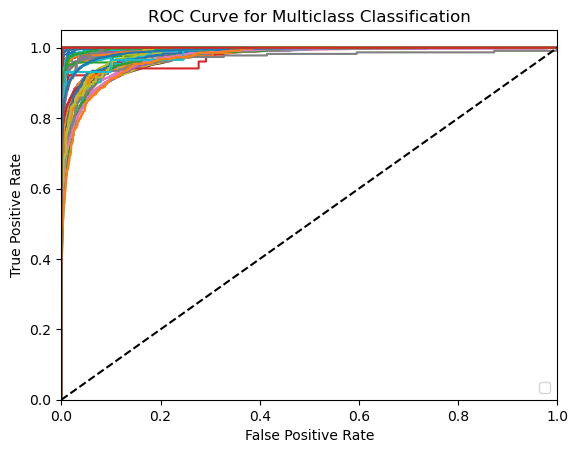

Accuracy 0.814
Precision 0.865
Recall 0.773
F1-Score 0.810
ROC-AUC 0.990


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_23_24, y_train_23_24, test_size=0.2, random_state=42,stratify=y_train_23_24)

# Train a decision tree model
#clf = DecisionTreeClassifier(random_state=42)
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#MLF_classifer_loss_acc(history)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Predict the classes for the test set
#y_test_pred_prob = model.predict(X_test)
#y_pred = np.argmax(y_test_pred_prob, axis=1)
# Convert one-hot encoded y_test back to original labels
#y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(model, 'XGBClassifier_2024.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoders, 'label_encoders.pkl')
#joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

In [20]:
##################### Now testing with tabnet and trined model month wise

In [ ]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Load the saved models, scaler, and label encoder
xgb_model = joblib.load('Tabular_Transformer_XGBoost.pkl')


# Assuming X_test_24 and y_test_24 are available
X_test_24['Movement_Date'] = pd.to_datetime(X_test_24['Movement_Date'])

# Scale X_test_24 using the same scaler as X_train
X_test_24_scaled = scaler.transform(X_test_24.drop(columns=["Movement_Date", "Month"], axis=1))  # Remove 'Movement_Date' and 'Month'

# Extract TabNet Features from X_test_24
X_test_24_transformed = tabnet.predict_proba(X_test_24_scaled)

# Use XGBoost model to predict on transformed X_test_24 features
y_pred_test_24 = xgb_model.predict(X_test_24_transformed)

# Evaluate the overall performance on the transformed X_test_24 features
accuracy = accuracy_score(y_test_24, y_pred_test_24)
precision = precision_score(y_test_24, y_pred_test_24, average='macro')
recall = recall_score(y_test_24, y_pred_test_24, average='macro')
f1 = f1_score(y_test_24, y_pred_test_24, average='macro')

# ROC curve and AUC (using `roc_auc_score`)

roc_auc = train_auca_roca_fun(X_test_24_transformed, xgb_model, y_test_final)

print("Overall Accuracy %.3f" % accuracy)
print("Overall Precision %.3f" % precision)
print("Overall Recall %.3f" % recall)
print("Overall F1-Score %.3f" % f1)
print("Overall ROC-AUC %.3f" % roc_auc)

# Create a DataFrame to store the month-wise results
month_results = []

# Add a 'Month' column for grouping by month (if not already done)
X_test_24['Month'] = X_test_24['Movement_Date'].dt.to_period('M')

# Iterate over each month in the dataset and evaluate month-wise
for month in X_test_24['Month'].unique():
    print(f"\nTesting for month: {month}")
    
    # Subset the data for the current month
    X_month = X_test_24[X_test_24['Month'] == month].drop(columns=["Movement_Date", "Month"], axis=1)
    y_month = y_test_24[X_test_24['Month'] == month]

    # Scale the features for the current month
    X_month_scaled = scaler.transform(X_month)
    
    # Extract features for the current month using TabNet
    X_month_transformed = tabnet.predict_proba(X_month_scaled)
    
    # Make predictions using the XGBoost model
    y_pred_month = xgb_model.predict(X_month_transformed)
    
    # Calculate the metrics for this month
    accuracy_month = accuracy_score(y_month, y_pred_month)
    precision_month = precision_score(y_month, y_pred_month, average='macro')
    recall_month = recall_score(y_month, y_pred_month, average='macro')
    f1_month = f1_score(y_month, y_pred_month, average='macro')

    # ROC curve and AUC for this month

    roc_auc_month = train_auca_roca_fun(X_month_transformed, xgb_model, y_month)

    # Store the results for this month
    month_results.append({
        'Month': str(month),
        'Accuracy': accuracy_month,
        'Precision': precision_month,
        'Recall': recall_month,
        'F1 Score': f1_month,
        'ROC-AUC': roc_auc_month
    })

# Convert the results to a DataFrame for tabulated output
month_results_df = pd.DataFrame(month_results)

# Display the tabulated results
print("\nMonth-wise Evaluation Results:")
print(month_results_df)



In [ ]:
############ Month wise resluts including roc-auc, accuracy, precision, recall, F1-score

2024-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


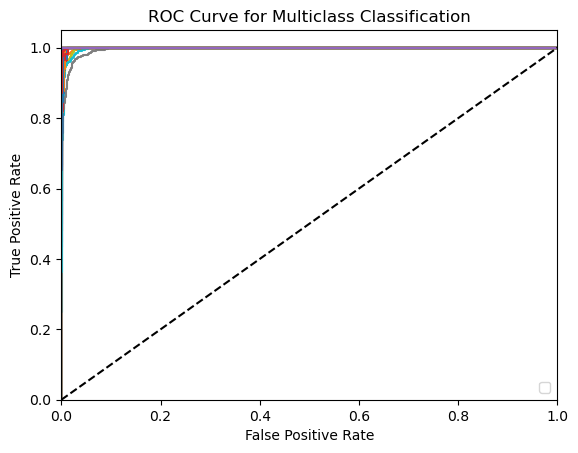

Accuracy 0.834
Precision 0.117
Recall 0.111
F1-Score 0.114
ROC-AUC 1.000
2024-02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


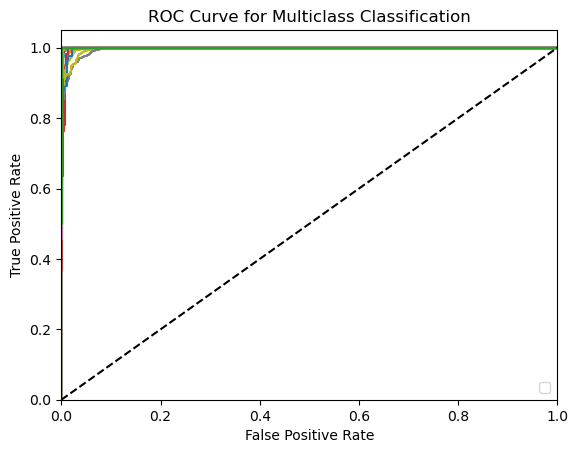

Accuracy 0.826
Precision 0.123
Recall 0.115
F1-Score 0.119
ROC-AUC 1.000
2024-03


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


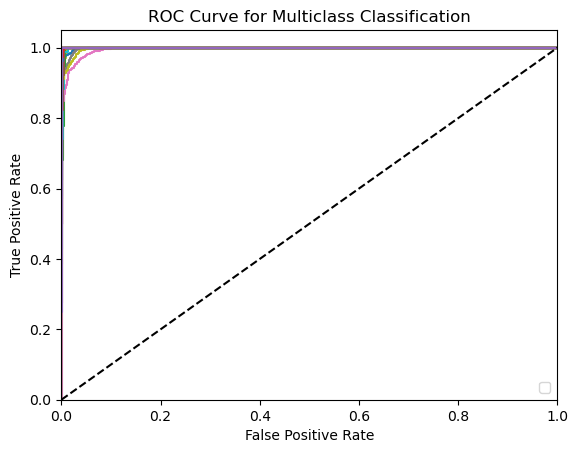

Accuracy 0.821
Precision 0.116
Recall 0.109
F1-Score 0.112
ROC-AUC 1.000
2024-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


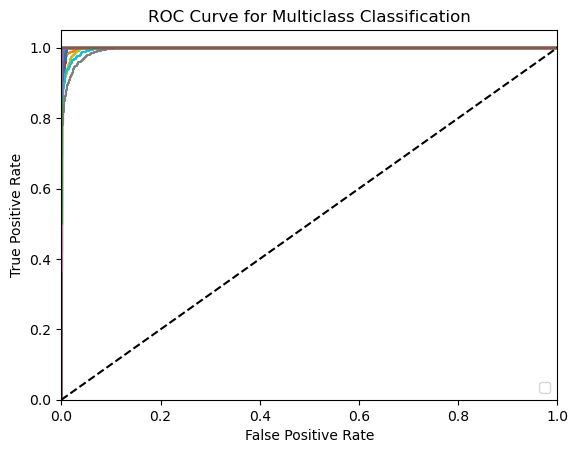

Accuracy 0.811
Precision 0.115
Recall 0.107
F1-Score 0.111
ROC-AUC 1.000
2024-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


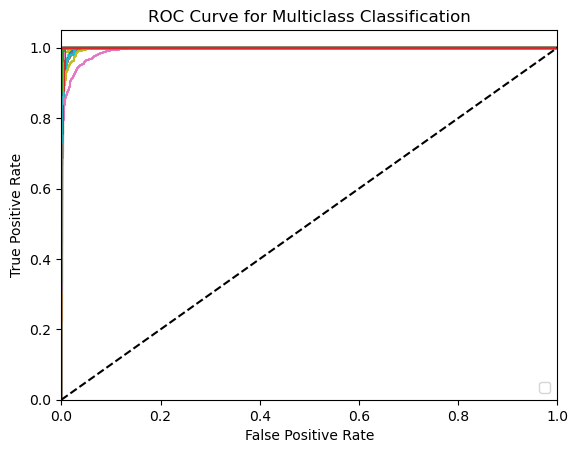

Accuracy 0.800
Precision 0.118
Recall 0.111
F1-Score 0.114
ROC-AUC 0.999
2024-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


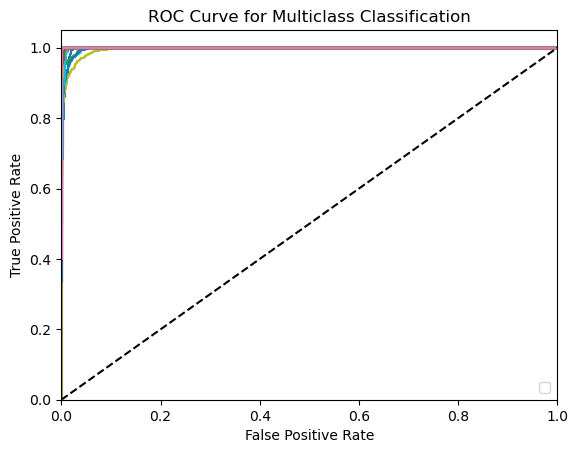

Accuracy 0.783
Precision 0.107
Recall 0.101
F1-Score 0.104
ROC-AUC 0.999
2024-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


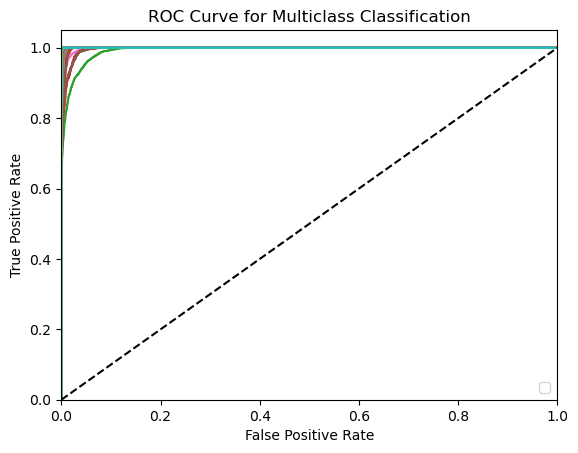

Accuracy 0.699
Precision 0.648
Recall 0.556
F1-Score 0.585
ROC-AUC 1.000
2024-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


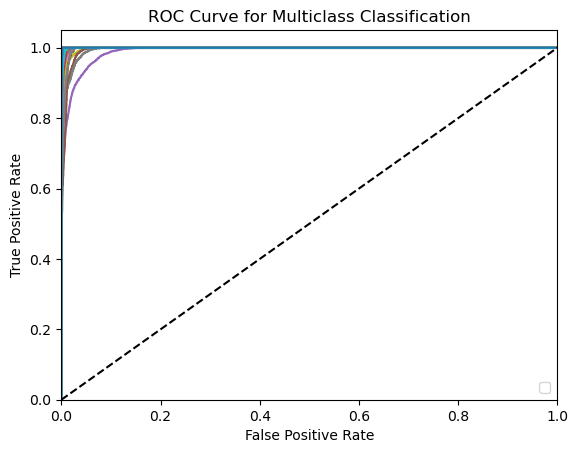

Accuracy 0.652
Precision 0.604
Recall 0.476
F1-Score 0.509
ROC-AUC 0.999
2024-09


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


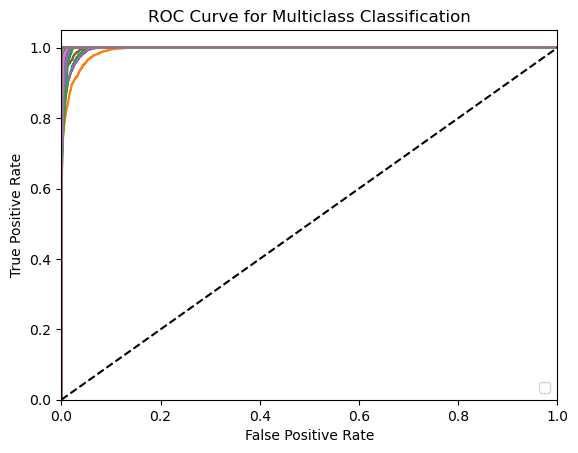

Accuracy 0.657
Precision 0.587
Recall 0.473
F1-Score 0.507
ROC-AUC 0.999
2024-10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


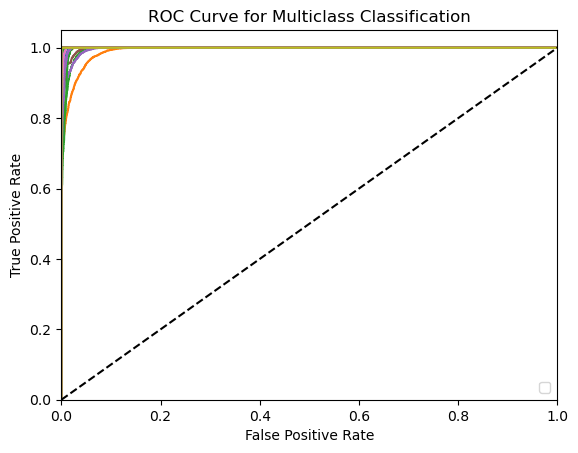

Accuracy 0.672
Precision 0.608
Recall 0.487
F1-Score 0.515
ROC-AUC 0.999
2024-11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


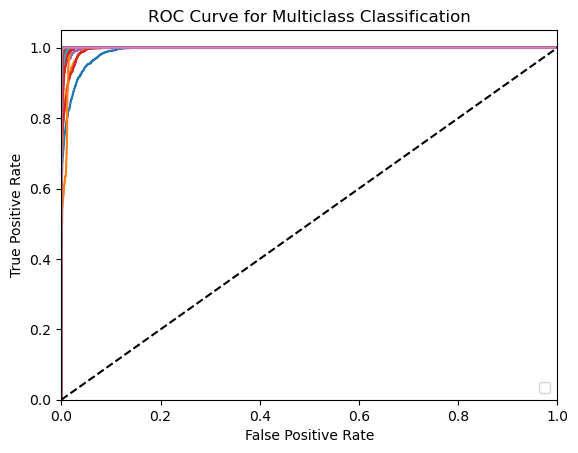

Accuracy 0.677
Precision 0.593
Recall 0.479
F1-Score 0.512
ROC-AUC 0.999
2024-12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


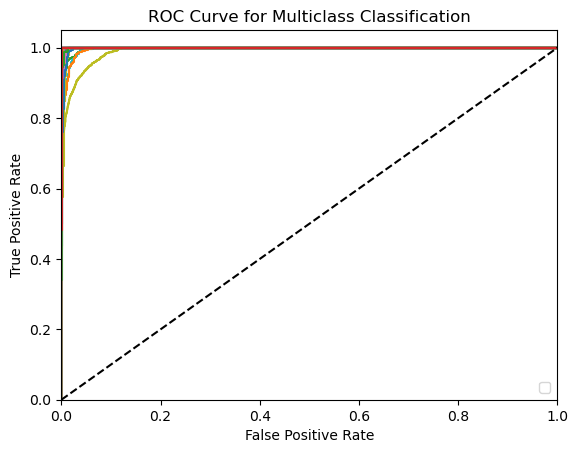

Accuracy 0.670
Precision 0.577
Recall 0.485
F1-Score 0.513
ROC-AUC 0.999


In [74]:
import warnings
import numpy as np

# Suppress specific warning from sklearn
warnings.simplefilter("ignore", category=UserWarning)
np.seterr(divide="ignore", invalid="ignore")  # Suppress divide-by-zero warnings

for year_month, group in df_2024_11.groupby(df_2024_11["Movement_Date"].dt.to_period('M')):
    # Assign features and target for the month
    print(year_month)
    X_test_24_1 = group.drop(columns=["Month",target_column, "Movement_Date"])  # Drop target column and Movement_Date from X
    y_pred_24_1 = model.predict(X_test_24_1)
    y_test_24_1 = group[target_column]  # Target column
    #accuracy = accuracy_score(y_test_24_1, y_pred_24_1)
    accuracy = accuarcy_drop_missing_classes(y_test_24_1, y_pred_24_1)
    precision = precision_score(y_test_24_1, y_pred_24_1, average='macro')
    recall = recall_score(y_test_24_1, y_pred_24_1, average='macro')
    f1 = f1_score(y_test_24_1, y_pred_24_1, average='macro')
    
    # ROC curve and AUC
    #fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
    #roc_auc = auc(fpr, tpr)
    roc_auc = train_auca_roca_fun(X_test_24_1, model, y_pred_24_1)
    print("Accuracy %.3f" % accuracy)
    print("Precision %.3f" % precision)
    print("Recall %.3f" % recall)
    print("F1-Score %.3f" % f1)
    print("ROC-AUC %.3f" % roc_auc)
    


In [20]:
# First pass to fit transformers for TfidfVectorizer and StandardScaler

In [4]:
file_path1 = [train_file1, train_file2, test_file]
#file_path1 = [test_file]

for file_path in file_path1:
    #print(file_path)
    if file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", decimal=',', chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
            
            # Fit TfidfVectorizer on text column
            tfidf_vectorizer.fit(chunk[text_column].astype(str))
            
            # Fit StandardScaler on numeric columns (use the consistent numeric_columns)
            scaler.partial_fit(chunk[numeric_columns])
        print("first file done")
    elif file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
            
            # Fit TfidfVectorizer on text column
            tfidf_vectorizer.fit(chunk[text_column].astype(str))
            
            # Fit StandardScaler on numeric columns (use the consistent numeric_columns)
            scaler.partial_fit(chunk[numeric_columns])
        print("second file done")
    elif file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
            
            # Fit TfidfVectorizer on text column
            tfidf_vectorizer.fit(chunk[text_column].astype(str))
            
            # Fit StandardScaler on numeric columns (use the consistent numeric_columns)
            scaler.partial_fit(chunk[numeric_columns])
        print("third file done")


Index([    1,   105,   109,   121,   122,   134,   135,   136,   228,   233,
       ...
       99876, 99878, 99879, 99880, 99895, 99924, 99926, 99954, 99988, 99993],
      dtype='int64', length=6061)
Index([100021, 100023, 100032, 100039, 100045, 100048, 100069, 100073, 100075,
       100087,
       ...
       157250, 157256, 157273, 157275, 157276, 157285, 157288, 157289, 157311,
       157337],
      dtype='int64', length=3904)
first file done
Index([    5,    20,    23,    38,    45,    50,    55,    88,    97,   112,
       ...
       99916, 99920, 99941, 99943, 99967, 99971, 99975, 99992, 99993, 99994],
      dtype='int64', length=8371)
Index([100007, 100040, 100047, 100059, 100060, 100070, 100091, 100099, 100101,
       100115,
       ...
       199922, 199933, 199939, 199947, 199952, 199953, 199954, 199961, 199965,
       199972],
      dtype='int64', length=9086)
Index([200058, 200111, 200130, 200156, 200224, 200234, 200235, 200236, 200237,
       200256,
       ...
       2484

In [8]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(target_label_encoder, 'target_label_encoder.pkl')


['target_label_encoder.pkl']

In [26]:
# Second pass to transform data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.sparse import csr_matrix, hstack, vstack
import numpy as np
import joblib
import glob
import os
def fill(val):
    return '0'*(3-len(str(val))) + str(val)

def preprocess_data(df):
    #df = filtered_df
    #print(df.columns)
    df.rename(columns = {'Broken_Packages_Quantity':'Departure_Packages_Quantity'}, inplace = True)
    df.rename(columns = {'NST2007_3P':'NST2007'}, inplace = True)
    df = df.drop(columns = ["Movement_Date", "Harmonized_Code", "CN2007_8P_Label_EN", 'NST2007_3P_Label_EN', 'NST2007_2P', 'NST2007_2P_Label_EN'], axis = 1)
    df.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
    str_to_elimante = "000"
    df['NST2007'] = df['NST2007'].apply(fill)
    #df = df.replace({'01A': '019', '01B': '020'})
    no_desc = df[df["NST2007"]==str_to_elimante].index
    print(no_desc)
    df = df.drop(index = no_desc, axis=1)
    df =df[~df.isin([np.nan, np.NaN, np.inf, -np.inf])]
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.reset_index().drop(columns=["index"])
    return df

# Define chunk size for reading the data
chunk_size = 100000
# Load the datasets
train_file1 = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx"
#train_file2 = r"D:\Averio\NEXUS_project\Dataset\Caso de estudo 1 _ classification\Jun_Dec_2023_with_Date (1).csv"
train_file2 = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx"

# for single file
#test_file = r"D:\Averio\NEXUS_project\Dataset\Data 2024\Data 2024.csv"
test_file = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx"

base_dir = r'D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024'
# for mul
csv_pattern = os.path.join(base_dir, '**', '*.csv')
csv_files = glob.glob(csv_pattern, recursive=True)

file_path1 = [train_file1, train_file2, test_file]
#file_path1 = [test_file]

# Placeholder for the processed chunks
X_chunks = []
y_chunks = []

# Example column names
text_column = 'Descrição_Carga'  # Text column
categorical_columns = ['Container_Plate',
  'Message',
  'Embarkation_Port',
  'Disembarkation_Port',
  'Transhipment',
  'ISO_contentainer',
  'ISO_contentainer_Registry',
  'Container_State',
  'Weight','Departure_Weight'
  ]  # Categorical columns
target_column = 'NST2007'  # Target column
numeric_columns = ['Container_Tare',
  'Departure_Packages_Quantity',
  'Packages_Quantity',
  ]
 # Initialize transformers


In [2]:
############## load all pretrained transofrms
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')
target_label_encoder = joblib.load('target_label_encoder.pkl')


In [3]:
file_path1

['D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Jan_May_2023_after_preproc.xlsx',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Jun_Dec_2023_after_preproc.xlsx',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Test_data_2024_after_preproc.xlsx']

In [5]:
file_path1 = [train_file1, train_file2]

for file_path in file_path1:
    #print(file_path)
    if file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", decimal=',', chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
                # Transform text column
            text_features = tfidf_vectorizer.transform(chunk[text_column].astype(str))
            
            # Transform categorical columns
            for col in categorical_columns:
                chunk[col] = label_encoders[col].transform(chunk[col].astype(str))
            
            # Transform numeric columns
            numeric_features = scaler.transform(chunk[numeric_columns])
            numeric_features_sparse = csr_matrix(numeric_features)
            
            # Combine categorical and numeric features into a sparse matrix
            categorical_numeric_features = csr_matrix(chunk[categorical_columns + numeric_columns].values)
            
            # Combine text features with categorical and numeric features
            chunk_features = hstack([text_features, categorical_numeric_features])
            
            # Append the sparse matrix to the list
            X_chunks.append(chunk_features)
            
            # Encode and store the target column
  
            chunk[target_column] = chunk[target_column].apply(fill)
    
            y_transformed = target_label_encoder.transform(chunk[target_column].astype(str))
            y_chunks.append(y_transformed)
            print("first", np.unique(y_transformed))
        print("first file done")
    elif file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
                # Transform text column
            text_features = tfidf_vectorizer.transform(chunk[text_column].astype(str))
            
            # Transform categorical columns
            for col in categorical_columns:
                chunk[col] = label_encoders[col].transform(chunk[col].astype(str))
            
            # Transform numeric columns
            numeric_features = scaler.transform(chunk[numeric_columns])
            numeric_features_sparse = csr_matrix(numeric_features)
            
            # Combine categorical and numeric features into a sparse matrix
            categorical_numeric_features = csr_matrix(chunk[categorical_columns + numeric_columns].values)
            
            # Combine text features with categorical and numeric features
            chunk_features = hstack([text_features, categorical_numeric_features])
            
            # Append the sparse matrix to the list
            X_chunks.append(chunk_features)
            
            # Encode and store the target column
  
            chunk[target_column] = chunk[target_column].apply(fill)
    
            y_transformed = target_label_encoder.transform(chunk[target_column].astype(str))
            print("second", np.unique(y_transformed))
            y_chunks.append(y_transformed)
        print("second file done")

Index([    1,   105,   109,   121,   122,   134,   135,   136,   228,   233,
       ...
       99876, 99878, 99879, 99880, 99895, 99924, 99926, 99954, 99988, 99993],
      dtype='int64', length=6061)
first [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 63 65]
Index([100021, 100023, 100032, 100039, 100045, 100048, 100069, 100073, 100075,
       100087,
       ...
       157250, 157256, 157273, 157275, 157276, 157285, 157288, 157289, 157311,
       157337],
      dtype='int64', length=3904)
first [ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 63 64]
first file done
Index([    5,    20,    23,    38,    45,    50,    55,    88,    97,   112,
       ...
       99916, 99920, 99941, 99943, 99967, 99971, 99975, 99992, 99993, 999

In [23]:
file_path1

['D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Jan_May_2023_after_preproc.xlsx',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Jun_Dec_2023_after_preproc.xlsx']

In [22]:

for file_path in file_path1:
    #print(file_path)
    if file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jan_May_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", decimal=',', chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
                # Transform text column
            text_features = tfidf_vectorizer.transform(chunk[text_column].astype(str))
            
            # Transform categorical columns
            for col in categorical_columns:
                chunk[col] = label_encoders[col].transform(chunk[col].astype(str))
            
            # Transform numeric columns
            numeric_features = scaler.transform(chunk[numeric_columns])
            numeric_features_sparse = csr_matrix(numeric_features)
            
            # Combine categorical and numeric features into a sparse matrix
            categorical_numeric_features = csr_matrix(chunk[categorical_columns + numeric_columns].values)
            
            # Combine text features with categorical and numeric features
            chunk_features = hstack([text_features, categorical_numeric_features])
            
            # Append the sparse matrix to the list
            X_chunks.append(chunk_features)
            
            # Encode and store the target column
  
            chunk[target_column] = chunk[target_column].apply(fill)
    
            y_transformed = target_label_encoder.transform(chunk[target_column].astype(str))
            y_chunks.append(y_transformed)
            print("first", np.unique(y_transformed))
        print("first file done")
        'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Test_data_2024_after_preproc.xlsx'
    elif file_path == r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Jun_Dec_2023_after_preproc.xlsx":
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
                # Transform text column
            text_features = tfidf_vectorizer.transform(chunk[text_column].astype(str))
            
            # Transform categorical columns
            for col in categorical_columns:
                chunk[col] = label_encoders[col].transform(chunk[col].astype(str))
            
            # Transform numeric columns
            numeric_features = scaler.transform(chunk[numeric_columns])
            numeric_features_sparse = csr_matrix(numeric_features)
            
            # Combine categorical and numeric features into a sparse matrix
            categorical_numeric_features = csr_matrix(chunk[categorical_columns + numeric_columns].values)
            
            # Combine text features with categorical and numeric features
            chunk_features = hstack([text_features, categorical_numeric_features])
            
            # Append the sparse matrix to the list
            X_chunks.append(chunk_features)
            
            # Encode and store the target column
  
            chunk[target_column] = chunk[target_column].apply(fill)
    
            y_transformed = target_label_encoder.transform(chunk[target_column].astype(str))
            print("second", np.unique(y_transformed))
            y_chunks.append(y_transformed)
        print("second file done")
        
    elif file_path == 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Test_data_2024_after_preproc.xlsx':
        
        for df in pd.read_csv(file_path, encoding="UTF-8", delimiter=",",on_bad_lines="skip", chunksize=chunk_size):
            chunk = preprocess_data(df)
            chunk[numeric_columns] = chunk[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
                # Transform text column
            text_features = tfidf_vectorizer.transform(chunk[text_column].astype(str))
            
            # Transform categorical columns
            for col in categorical_columns:
                chunk[col] = label_encoders[col].transform(chunk[col].astype(str))
            
            # Transform numeric columns
            numeric_features = scaler.transform(chunk[numeric_columns])
            numeric_features_sparse = csr_matrix(numeric_features)
            
            # Combine categorical and numeric features into a sparse matrix
            categorical_numeric_features = csr_matrix(chunk[categorical_columns + numeric_columns].values)
            
            # Combine text features with categorical and numeric features
            chunk_features = hstack([text_features, categorical_numeric_features])
            
            # Append the sparse matrix to the list
            X_chunks.append(chunk_features)
            
            # Encode and store the target column
  
            chunk[target_column] = chunk[target_column].apply(fill)
    
            y_transformed = target_label_encoder.transform(chunk[target_column].astype(str))
            print("second", np.unique(y_transformed))
            y_chunks.append(y_transformed)
        print("third file done")

Index([    1,   105,   109,   121,   122,   134,   135,   136,   228,   233,
       ...
       99876, 99878, 99879, 99880, 99895, 99924, 99926, 99954, 99988, 99993],
      dtype='int64', length=6061)
first [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 63 65]
Index([100021, 100023, 100032, 100039, 100045, 100048, 100069, 100073, 100075,
       100087,
       ...
       157250, 157256, 157273, 157275, 157276, 157285, 157288, 157289, 157311,
       157337],
      dtype='int64', length=3904)
first [ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 63 64]
first file done
Index([    5,    20,    23,    38,    45,    50,    55,    88,    97,   112,
       ...
       99916, 99920, 99941, 99943, 99967, 99971, 99975, 99992, 99993, 999

ValueError: y contains previously unseen labels: '100695'

In [8]:
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
X_sparse, len(y)

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 12112638 stored elements and shape (718624, 947)>,
 718624)

In [18]:
X_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12112638 stored elements and shape (718624, 947)>

In [20]:
import numpy as np
import pandas as pd
final_features = tfidf_vectorizer.get_feature_names_out().tolist() + categorical_columns + numeric_columns
X_dense = X_sparse.toarray()  # Convert sparse matrix to dense format
# Convert to Pandas DataFrame
df = pd.DataFrame(X_dense, columns=final_features)

In [21]:
df

,aamcppz,abatidores,absorbedores,absorbentes,absorption,accesorios,accessory,acero,acid,acido,...,Transhipment,ISO_contentainer,ISO_contentainer_Registry,Container_State,Weight,Departure_Weight,Movement_Date,Container_Tare,Departure_Packages_Quantity,Packages_Quantity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,29.0,71.0,0.0,24615.0,78374.0,0.0,3850.0,103.0,68.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,29.0,79.0,0.0,103982.0,89007.0,1.0,3870.0,22.0,22.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29.0,71.0,0.0,91210.0,49309.0,2.0,3890.0,464.0,16.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29.0,71.0,0.0,78554.0,36819.0,3.0,3900.0,286.0,11.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,29.0,71.0,0.0,59130.0,16347.0,4.0,3700.0,96.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,17.0,0.0,66694.0,31038.0,217641.0,3610.0,2.0,1.0
718620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,17.0,0.0,66694.0,30363.0,217641.0,3900.0,2.0,1.0
718621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,17.0,0.0,15226.0,30690.0,217642.0,4300.0,7.0,1.0
718622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,17.0,0.0,15226.0,30507.0,217642.0,3670.0,7.0,1.0


In [147]:
# training 

In [ ]:
# Combine all chunks into a single sparse matrix
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
from tensorflow.keras.utils import to_categorical

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42, stratify=y)

# Train a decision tree model
#clf = DecisionTreeClassifier(random_state=42)
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

#clf = RandomForestClassifier(max_depth=60)
############ XGBClassifier #################################################
# Step 4: Train the XGBClassifier
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric=['mlogloss', 'merror'])

eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)
# Step 4: Evaluate the Classifier
y_pred = xgb_clf.predict(X_test)
print("\nClassifier: XGBoost")
clf = trining_loss_plot(xgb_clf)
#clf.fit(X_train, y_train)

# Initialize the LGBMClassifier
# Initialize the LGBMClassifier with verbose parameter in params
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'verbose': -1
}
#model = LGBMClassifier(**params)

# Train the model with evaluation set
#model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='multi_logloss')

#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))
#clf = LGBMClassifier_trining_loss_plot(model)

# Initialize the MLPClassifier
# Convert labels to one-hot encoding
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

# Build the MLP model
#model = Sequential()
#model.add(Dense(100, input_dim=X_sparse.shape[1], activation='relu'))
#model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and capture the history
#history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), verbose=0)

#model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#MLF_classifer_loss_acc(history)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
# Predict the classes for the test set
#y_test_pred_prob = model.predict(X_test)
#y_pred = np.argmax(y_test_pred_prob, axis=1)
# Convert one-hot encoded y_test back to original labels
#y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(model, 'XGBClassifier.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoders, 'label_encoders.pkl')
#joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       186
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.96      0.94      0.95       949
           4       0.95      0.82      0.88       139
           5       0.96      0.98      0.97       423
           6       0.94      0.88      0.91      1233
           7       0.95      0.95      0.95       527
           8       1.00      1.00      1.00         9
           9       0.96      0.93      0.94      1066
          10       0.87      0.86      0.86       141
          11       1.00      0.92      0.96        12
          12       1.00      0.96      0.98        49
          13       0.97      0.89      0.93       238
          14       0.97      0.96      0.97       119
          15       0.97      0.86      0.91        37
          16       1.00      0.25      0.40         4
          17       0.83    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.


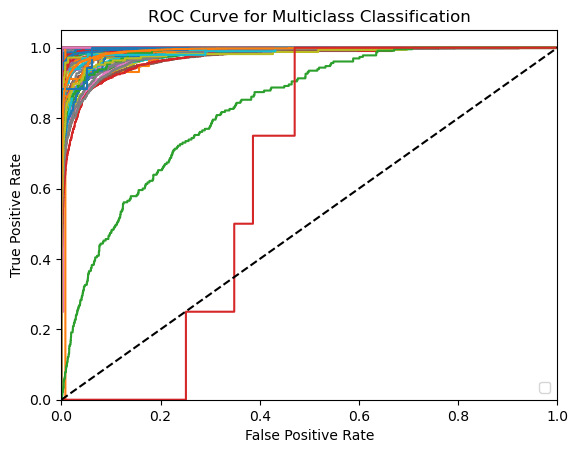

Accuracy 0.825
Precision 0.819
Recall 0.729
F1-Score 0.764
ROC-AUC 0.983


In [43]:
import xgboost as xgb
#MLF_classifer_loss_acc(history)
# Remap y to sequential integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
num_classes = len(np.unique(y_train))
model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Predict the classes for the test set
#y_test_pred_prob = model.predict(X_test)
#y_pred = np.argmax(y_test_pred_prob, axis=1)
# Convert one-hot encoded y_test back to original labels
#y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(model, 'XGBClassifier.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoders, 'label_encoders.pkl')
#joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)


In [14]:
def auca_roca_fun(X_new):
    y_score = clf.predict_proba(X_new)
    
    n_classes = y_score.shape[1]
    y_true_binarized = label_binarize(y_true, classes=clf.classes_)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        if np.sum(y_true_binarized[:, i]) == 0:
            #print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    average_auc = np.mean(list(roc_auc.values()))
    # Plot all ROC curves
    plt.figure()
    nou = np.nan
    for i in range(n_classes):
        # print(type(roc_auc[i]))
        if np.sum(y_true_binarized[:, i]) == 0:
            print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        
        #plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i])
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    return average_auc

Month 1 DataFrame:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 12, skipping this class.
No positive samples in y_true for class 31, skipping this class.
No positive samples in y_true for class 62, skipping this class.


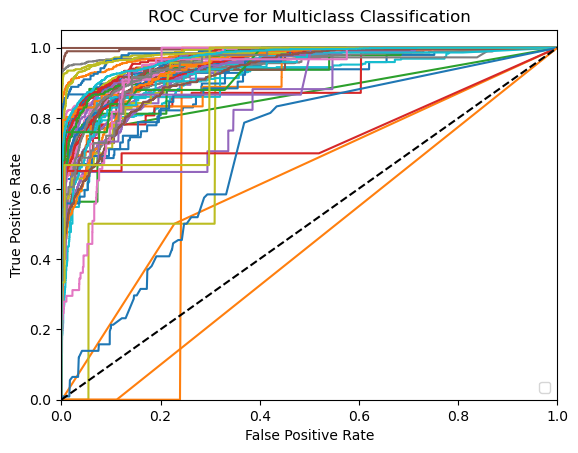

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.699
Precision 0.561
Recall 0.503
F1-Score 0.521
ROC-AUC 0.922
Month 2 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 8, skipping this class.
No positive samples in y_true for class 62, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


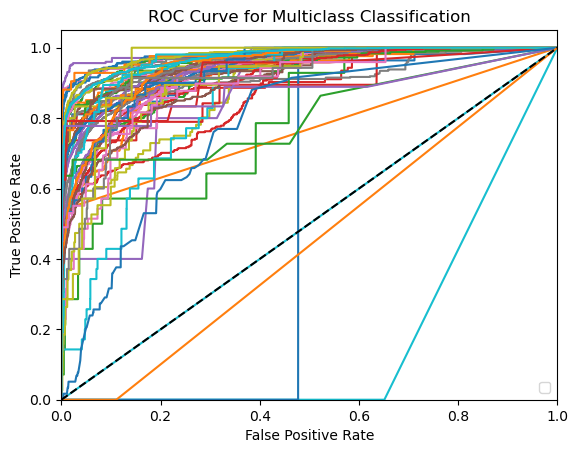

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.681
Precision 0.534
Recall 0.463
F1-Score 0.477
ROC-AUC 0.894
Month 3 DataFrame:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


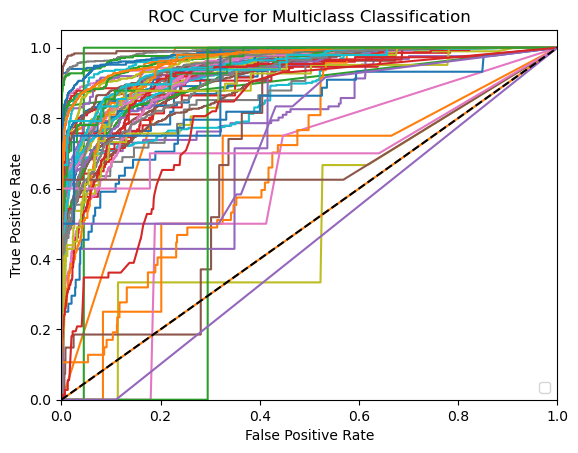

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.661
Precision 0.479
Recall 0.420
F1-Score 0.435
ROC-AUC 0.880
Month 4 DataFrame:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 31, skipping this class.
No positive samples in y_true for class 62, skipping this class.


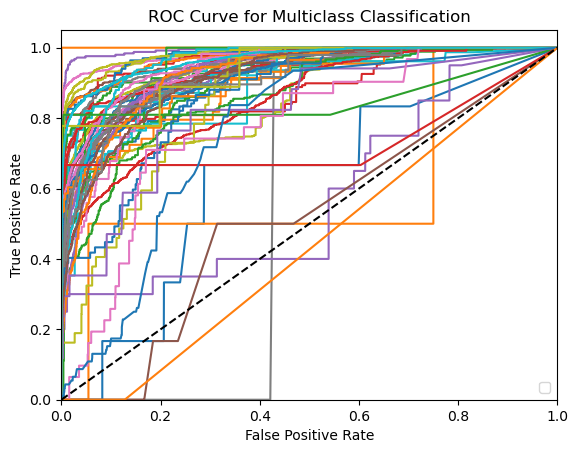

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.624
Precision 0.484
Recall 0.412
F1-Score 0.430
ROC-AUC 0.882
Month 5 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 8, skipping this class.
No positive samples in y_true for class 62, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


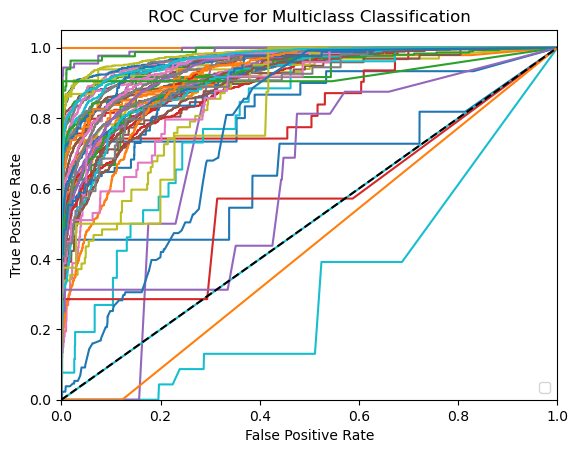

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.649
Precision 0.482
Recall 0.450
F1-Score 0.457
ROC-AUC 0.886
Month 6 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 8, skipping this class.
No positive samples in y_true for class 31, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


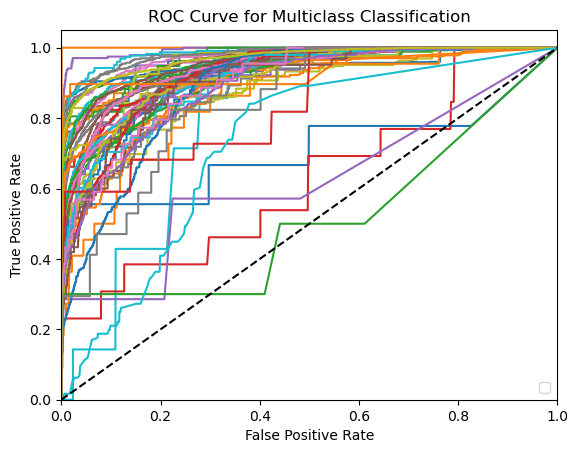

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.622
Precision 0.481
Recall 0.428
F1-Score 0.444
ROC-AUC 0.904
Month 7 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 8, skipping this class.
No positive samples in y_true for class 31, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


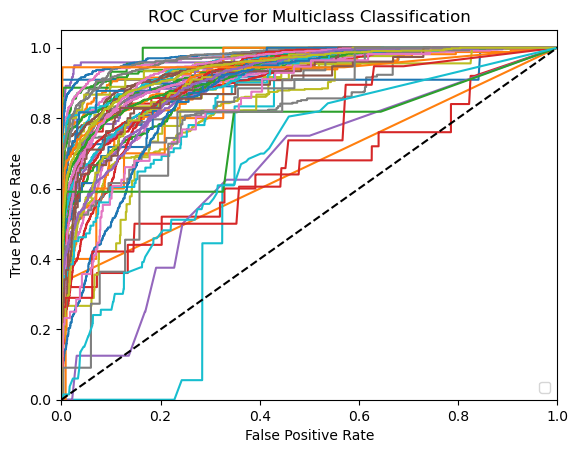

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.607
Precision 0.453
Recall 0.416
F1-Score 0.426
ROC-AUC 0.894
Month 8 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 31, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


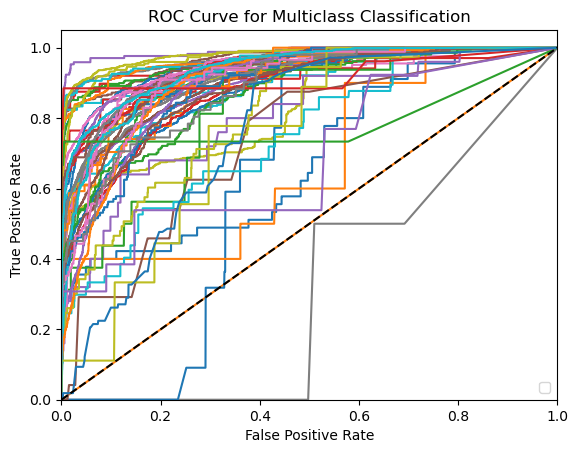

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.592
Precision 0.457
Recall 0.389
F1-Score 0.409
ROC-AUC 0.872
Month 9 DataFrame:
No positive samples in y_true for class 2, skipping this class.
No positive samples in y_true for class 31, skipping this class.
No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


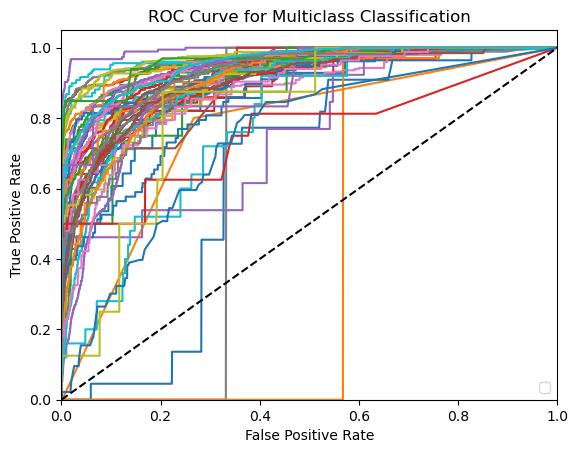

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.599
Precision 0.447
Recall 0.395
F1-Score 0.410
ROC-AUC 0.894
Month 10 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 2, skipping this class.
No positive samples in y_true for class 31, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.


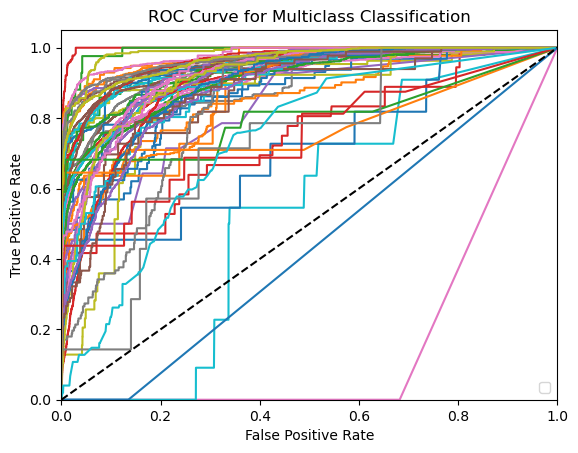

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.607
Precision 0.451
Recall 0.394
F1-Score 0.409
ROC-AUC 0.876
Month 11 DataFrame:
No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 2, skipping this class.
No positive samples in y_true for class 31, skipping this class.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


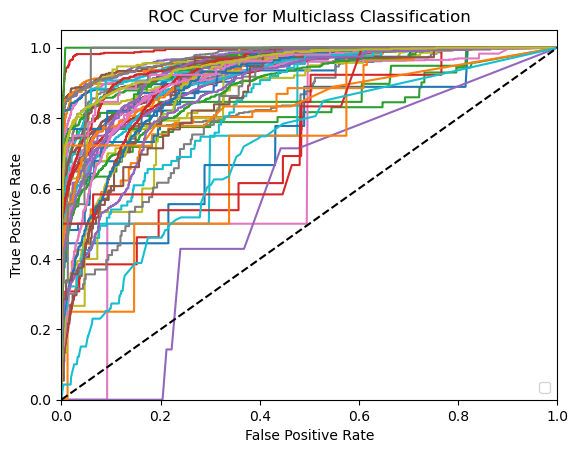

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.608
Precision 0.475
Recall 0.416
F1-Score 0.432
ROC-AUC 0.897
Month 12 DataFrame:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No positive samples in y_true for class 1, skipping this class.
No positive samples in y_true for class 2, skipping this class.
No positive samples in y_true for class 8, skipping this class.
No positive samples in y_true for class 31, skipping this class.
No positive samples in y_true for class 62, skipping this class.
No positive samples in y_true for class 64, skipping this class.


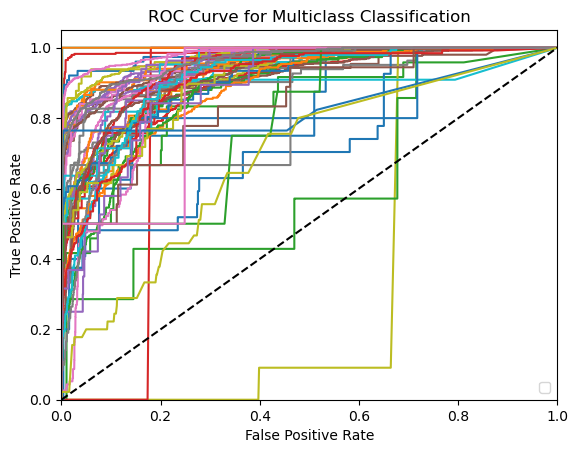

D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\Test_data_2024_after_preproc.xlsx
Accuracy 0.628
Precision 0.479
Recall 0.423
F1-Score 0.434
ROC-AUC 0.898


In [138]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.sparse import csr_matrix, hstack
import joblib
import numpy as np
# Binarize the labels
from sklearn.preprocessing import label_binarize
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the model and preprocessing objects
clf = joblib.load('stacking_random_LogisticRegression_XGBOOST.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')
target_label_encoder = joblib.load('target_label_encoder.pkl')

# Example column names
# Example column names
text_column = 'Descrição_Carga'  # Text column
categorical_columns = ['Container_Plate',
  'Message',
  'Embarkation_Port',
  'Disembarkation_Port',
  'Transhipment',
  'ISO_contentainer',
  'ISO_contentainer_Registry',
  'Container_State',
  'Weight','Departure_Weight'
  ]  # Categorical columns
target_column = 'NST2007'  # Target column
numeric_columns = ['Container_Tare',
  'Departure_Packages_Quantity',
  'Packages_Quantity',
  ]
def fill(val):
    return '0'*(3-len(str(val))) + str(val)
def preprocess_data(df):
    #df = filtered_df
    df.rename(columns = {'Broken_Packages_Quantity':'Departure_Packages_Quantity'}, inplace = True)
    df.rename(columns = {'NST2007_3P':'NST2007'}, inplace = True)
    df = df.drop(columns = ["Movement_Date", "Harmonized_Code", "CN2007_8P_Label_EN", 'NST2007_3P_Label_EN', 'NST2007_2P', 'NST2007_2P_Label_EN'], axis = 1)
    df.rename(columns = {'Cargo_Description':'Descrição_Carga'}, inplace = True)
    str_to_elimante = "000"
    df['NST2007'] = df['NST2007'].apply(fill)
    no_desc = df[df["NST2007"]==str_to_elimante].index
    #print(no_desc)
    df = df.drop(index = no_desc, axis=1)
    df =df[~df.isin([np.nan, np.NaN, np.inf, -np.inf])]
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.reset_index().drop(columns=["index"])
    return df

# Function to preprocess new data
def preprocess_new_data(df):
    # Track numeric columns (assuming they are the same as in training)
    #numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure numeric columns are in float or int format and handle missing values
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Transform text column
    text_features = tfidf_vectorizer.transform(df[text_column].astype(str))
    
    # Transform categorical columns
    for col in categorical_columns:
        df[col] = label_encoders[col].transform(df[col].astype(str))
    
    # Transform numeric columns
    numeric_features = scaler.transform(df[numeric_columns])
    numeric_features_sparse = csr_matrix(numeric_features)
    
    # Combine categorical and numeric features into a sparse matrix
    categorical_numeric_features = csr_matrix(df[categorical_columns + numeric_columns].values)
    
    # Combine text features with categorical and numeric features
    features = hstack([text_features, categorical_numeric_features])
    #features = features[:, selected_features]
    return features
# y_true = X_new["NST2007"]
def auca_roca_fun(X_new):
    y_score = clf.predict_proba(X_new)
    
    n_classes = y_score.shape[1]
    y_true_binarized = label_binarize(y_true, classes=clf.classes_)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        if np.sum(y_true_binarized[:, i]) == 0:
            #print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    average_auc = np.mean(list(roc_auc.values()))
    # Plot all ROC curves
    plt.figure()
    nou = np.nan
    for i in range(n_classes):
        # print(type(roc_auc[i]))
        if np.sum(y_true_binarized[:, i]) == 0:
            print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        
        #plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i])
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    return average_auc

#for test_file in reming_months:
import pandas as pd
# Create DataFrame
df = pd.read_csv(test_file, encoding="UTF-8", delimiter=",",on_bad_lines="skip", decimal=',')

date_column = "Movement_Date"

df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Ensure dates are parsed correctly

# Extract month from the date column
df["Movement_Date"] = df["Movement_Date"].dt.month

# Separate data into DataFrames for each month
monthly_dataframes = {month: group for month, group in df.groupby("Movement_Date")}

# Apply operations on each month's DataFrame
for month, month_df in monthly_dataframes.items():
    print(f"Month {month} DataFrame:")
    #print(month_df)  # Display the original DataFrame for this month
    #test_file = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\May.csv"
    new_data = month_df
    #print(new_data["Departure_Weight"])
    new_data = preprocess_data(new_data)
    #new_data = df
    
    y_true = target_label_encoder.transform(new_data['NST2007'].astype(str))
    # new_data = new_data.drop(columns = ["NST2007"], axis = 1)
    X_new = preprocess_new_data(new_data)
    
    # Make predictions
    y_pred_new = clf.predict(X_new)
    
    # Inverse transform the target labels if needed
    predicted_labels = target_label_encoder.inverse_transform(y_pred_new)
    
    # Output predictions
    # print(predicted_labels)
    
    # If the new data has true labels, evaluate the model
    if target_column in new_data.columns:
        y_true_new = target_label_encoder.transform(new_data[target_column].astype(str))
        
        # Calculate metrics
        #accuracy1 = accuracy_score(y_true_new, y_pred_new)
        #Accuracy claucaulation after excluding any missig classes in y_true and y_pred
        accuracy = accuarcy_drop_missing_classes(y_true_new, y_pred_new)
        precision = precision_score(y_true_new, y_pred_new, average='macro')
        recall = recall_score(y_true_new, y_pred_new, average='macro')
        f1 = f1_score(y_true_new, y_pred_new, average='macro')
    
        # ROC curve and AUC
        #fpr, tpr, _ = roc_curve(y_true_new, clf.predict_proba(X_new)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
        roc_auc = auca_roca_fun(X_new)
        print(test_file)
        print("Accuracy %.3f" % accuracy)
        #print("Accuracy1 %.3f" % accuracy1)
        print("Precision %.3f" % precision)
        print("Recall %.3f" % recall)
        print("F1-Score %.3f" % f1)
        print("ROC-AUC %.3f" % roc_auc)
    #break




In [15]:

import numpy as np
from sklearn.metrics import accuracy_score
def accuarcy_drop_missing_classes(y_true_new, y_pred_new):
    # Example data
    y_true = y_true_new
    y_pred = y_pred_new  # Predicted labels
    
    # Find unique classes in y_true and y_pred
    unique_y_true = np.unique(y_true)
    unique_y_pred = np.unique(y_pred)
    
    # Identify classes that are missing in either y_true or y_pred
    missing_classes = np.setdiff1d(
        np.union1d(unique_y_true, unique_y_pred),
        np.intersect1d(unique_y_true, unique_y_pred),
    )
    
    # Create a mask to exclude missing classes
    mask = ~np.isin(y_true, missing_classes)
    
    # Filter y_true and y_pred using the mask
    filtered_y_true = y_true[mask]
    filtered_y_pred = y_pred[mask]
    
    # Calculate accuracy
    accuracy = accuracy_score(filtered_y_true, filtered_y_pred)
    return accuracy

In [ ]:
import pandas as pd
# Create DataFrame
df = pd.read_csv(r"D:\Averio\NEXUS_project\Dataset\Data 2024\Data 2024.csv", encoding="UTF-8", delimiter=";",on_bad_lines="skip", decimal=',')

date_column = "Movement_Date"

df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Ensure dates are parsed correctly

# Extract month from the date column
df["Movement_Date"] = df["Movement_Date"].dt.month

# Separate data into DataFrames for each month
monthly_dataframes = {month: group for month, group in df.groupby("Movement_Date")}

# Apply operations on each month's DataFrame
for month, month_df in monthly_dataframes.items():
    print(f"Month {month} DataFrame:")
    #print(month_df)  # Display the original DataFrame for this month
    #test_file = r"D:\Averio\NEXUS_project\Dataset\Test_Dataset_2024\May.csv"
    new_data = month_df
    print(len(new_data))
    #print(new_data["Departure_Weight"])
    new_data = preprocess_data(new_data)
    print(len(new_data))
    #new_data = df
    
    

In [16]:
def trining_loss_plot(xgb_clf):
    # Step 5: Plot Training Accuracy and Loss
    results = xgb_clf.evals_result()
    
    # Plot training and test loss
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
    ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Test Loss')
    ax[0].set_title('XGBoost Log Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Log Loss')
    ax[0].legend(loc='best')
    
    # Plot training and test accuracy
    ax[1].plot(x_axis, results['validation_0']['merror'], label='Train Error')
    ax[1].plot(x_axis, results['validation_1']['merror'], label='Test Error')
    ax[1].set_title('XGBoost Classification Error')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Classification Error')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    return xgb_clf
    

    

In [ ]:
##################   Target distribuation plot ##################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
y_true_new = y_true_new = target_label_encoder.transform(df_test[target_column].astype(str))
# Example target array (replace with your actual data)
target_array = y_true_new #np.array([0, 1, 1, 0, 2, 2, 2, 1, 3, 3, 3, 3, 4, 0, 0])

# Count occurrences of each class
unique_classes, class_counts = np.unique(target_array, return_counts=True)

# Plot the target distribution with log scale
plt.figure(figsize=(318, 80))
plt.bar(unique_classes, class_counts, color='gray', log=False)
#plt.yscale('log')
# Add labels, title, and log scale
#plt.title('Target Distribution (Log Scale)', fontsize=316)
plt.title('Target Distribution', fontsize=316)

plt.xlabel('Target Classes', fontsize=214)
#plt.ylabel('Count (Log Scale)', fontsize=214)
plt.ylabel('Count - (in $10^6$)', fontsize=214)
#plt.ylabel('Count - (log scale)', fontsize=214)

plt.xticks(unique_classes, [f'{c}' for c in unique_classes], fontsize=120)
plt.yticks(fontsize=212)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [17]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(first_20_rows, y_first_20_rows, test_size=0.2, random_state=42)
from sklearn.preprocessing import label_binarize

def LGBMClassifier_trining_loss_plot(model):
    
    # Extract evaluation results
    results = model.evals_result_
    
    # Plot training and validation log loss
    epochs = len(results['training']['multi_logloss'])
    x_axis = range(0, epochs)
    plt.figure(figsize=(12, 6))
    
    # Plot log loss
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['training']['multi_logloss'], label='Train')
    plt.plot(x_axis, results['valid_1']['multi_logloss'], label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title('LightGBM Log Loss')
    
    # Calculate accuracy for each epoch
    train_accuracy = [accuracy_score(y_train, np.argmax(model.predict_proba(X_train, num_iteration=i + 1), axis=1)) for i in x_axis]
    test_accuracy = [accuracy_score(y_test, np.argmax(model.predict_proba(X_test, num_iteration=i + 1), axis=1)) for i in x_axis]
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, train_accuracy, label='Train')
    plt.plot(x_axis, test_accuracy, label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('LightGBM Accuracy')
    
    plt.tight_layout()
    plt.show()
    return model

def train_auca_roca_fun(X_test, clf, y_true):
    y_score = clf.predict_proba(X_test)
    #print(len(X_test))
    n_classes = y_score.shape[1]
    y_true_binarized = label_binarize(y_true, classes=clf.classes_)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        if np.sum(y_true_binarized[:, i]) == 0:
            #print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    average_auc = np.mean(list(roc_auc.values()))
    # Plot all ROC curves
    plt.figure()
    nou = np.nan
    for i in range(n_classes):
        # print(type(roc_auc[i]))
        if np.sum(y_true_binarized[:, i]) == 0:
            print(f"No positive samples in y_true for class {i}, skipping this class.")
            continue
        
        #plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i])
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    return average_auc

In [9]:
import scipy.sparse as sp

# Step 2: Extract the First 20 Rows and All Columns
first_20_rows = X_sparse[:200, :]
first_20_rows = sp.csr_matrix(first_20_rows)
y_first_20_rows = np.random.randint(0, 21, size=200)
#y_first_20_rows

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


def MLF_classifer_loss_acc(history):
    # Plotting the training loss and accuracy
    epochs = range(1, 101)
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

# Assuming y_train and y_test are your target arrays
train_classes = np.unique(y)
test_classes = np.unique(y_test)

# Find classes missing in train or test
missing_in_train = set(test_classes) - set(train_classes)
missing_in_test = set(train_classes) - set(test_classes)

# Print results
print(f"Classes in train: {sorted(train_classes)}")
print(f"Classes in test: {sorted(test_classes)}")
print(f"Classes missing in train: {sorted(missing_in_train)}")
print(f"Classes missing in test: {sorted(missing_in_test)}")


In [6]:
################### FOR LGBMClassifier trainign program 

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import lightgbm as lgb
# Example data (replace this with your actual data)
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
# Split the data into training and temporary sets (train + remaining = 80% of data)
X_train, X_temp, y_train, y_temp = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (validation + test = 20% of data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Prepare the dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
# Define LightGBM parameters for multi-class classification
params = {
    'objective': 'multiclass',      # or 'binary' for binary classification
    'num_class': len(np.unique(y)),                 # Number of classes for multi-class classification
    'boosting_type': 'gbdt',        # Gradient Boosting Decision Tree
    'metric': 'multi_logloss',      # Evaluation metric
    'learning_rate': 0.05,          # Learning rate
    'num_leaves': 64,               # Number of leaves in a tree
    'max_depth': -1,                # No limit on tree depth
    'min_data_in_leaf': 50,         # Minimum number of samples in a leaf
    'bagging_fraction': 0.8,        # Fraction of data for bagging
    'bagging_freq': 5,              # Perform bagging every 5 iterations
    'feature_fraction': 0.8,        # Fraction of features for building a tree
    'lambda_l1': 1.0,               # L1 regularization to prevent overfitting
    'lambda_l2': 1.0,               # L2 regularization to prevent overfitting
    'class_weight':  'balanced',
    'verbose': 1                   # Suppress output
}

# Train the model with early stopping
model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],  # Training and validation sets
    num_boost_round=2000,              # Maximum number of boosting rounds
    #early_stopping_rounds=50           # Stop if validation score doesn't improve
)


# Predictions on the validation set
y_pred_val = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis=1)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy_val:.4f}")
# Access the best iteration
best_iteration = model.best_iteration  # Correct attribute
print(f"Best Iteration: {best_iteration}")

# Predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.4f}")


In [7]:
# for Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import joblib
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
# Example dataset and splitting (replace with your own)
from sklearn.datasets import make_classification

X_train, X_temp, y_train, y_temp = train_test_split(X_sparse, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize model
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500, random_state=42)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
no_improve_epochs = 0

# Training loop
for epoch in range(1, 2):  # Train for up to 100 epochs
    model.fit(X_train, y_train)
    print(f"Number of iterations: {model.n_iter_}")
    # Compute validation loss
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        joblib.dump(model, 'Logistic_Regression.pkl')  # Save best model
        no_improve_epochs = 0  # Reset counter
        print(f"Epoch {epoch}: Best model saved with Val Loss: {val_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f"Epoch {epoch}: No improvement in Val Loss. Patience: {no_improve_epochs}/{patience}")
    
    # Stop if no improvement for 'patience' epochs
    if no_improve_epochs >= patience:
        print("Early stopping triggered.")
        break

# Evaluate on the test set
test_preds = model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Plotting metrics in a single figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot losses
axs[0].plot(train_losses, label='Train Loss', color='blue')
axs[0].plot(val_losses, label='Validation Loss', color='orange')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Log Loss')
axs[0].legend()

# Plot accuracies
axs[1].plot(train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#Bayesian Optimization with Optuna for XGBoost
#For more efficient hyperparameter optimization, use Optuna:

In [54]:
import optuna
from xgboost import XGBClassifier
# Combine all chunks into a single sparse matrix
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
encoder = LabelEncoder()

# Fit and transform the data
y_encoder = encoder.fit_transform(y) 
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y_encoder, test_size=0.2, random_state=42, stratify=y)

def objective(trial):
    # Define hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    # Initialize model with parameters
    model = XGBClassifier(random_state=42, **params)

    # Train model
    model.fit(X_train, y_train)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, model.predict(X_test))
    return accuracy

# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best Parameters:", study.best_params )


[I 2025-01-23 07:32:57,250] A new study created in memory with name: no-name-70ca7428-d0a1-43ec-a704-16470609dbb3
[I 2025-01-23 07:40:01,237] Trial 0 finished with value: 0.7885692783677565 and parameters: {'max_depth': 8, 'learning_rate': 0.04632643720645617, 'n_estimators': 103, 'subsample': 0.6065153291148524, 'colsample_bytree': 0.9925970896505538}. Best is trial 0 with value: 0.7885692783677565.
[I 2025-01-23 07:48:26,216] Trial 1 finished with value: 0.814602670234412 and parameters: {'max_depth': 9, 'learning_rate': 0.04869650923386922, 'n_estimators': 103, 'subsample': 0.9916673384197978, 'colsample_bytree': 0.9087483165529021}. Best is trial 1 with value: 0.814602670234412.
[I 2025-01-23 07:53:45,727] Trial 2 finished with value: 0.8188393678401205 and parameters: {'max_depth': 8, 'learning_rate': 0.09821413155123039, 'n_estimators': 88, 'subsample': 0.7276138155297114, 'colsample_bytree': 0.665188463065696}. Best is trial 2 with value: 0.8188393678401205.
[I 2025-01-23 07:59:

AttributeError: 'Study' object has no attribute 'best_params_'

In [60]:
print("Best Parameters:", study.best_params )
# Retrieve best parameters and model
print("Best Hyperparameters:", study.best_params)
print("Best Trial Value (Score):", study.best_trial.value)

# Get the best model from user attributes
best_model = study.best_trial.user_attrs["best_model"]
accuracy = accuracy_score(y_test, best_model.predict(X_test))
print("Final Accuracy with Best Model:", accuracy)
Best Parameters: {'max_depth': 10, 'learning_rate': 0.1881186603053861, 'n_estimators': 170, 'subsample': 0.9277389356354614, 'colsample_bytree': 0.9397123327729827}
Best Hyperparameters: {'max_depth': 10, 'learning_rate': 0.1881186603053861, 'n_estimators': 170, 'subsample': 0.9277389356354614, 'colsample_bytree': 0.9397123327729827}
Best Trial Value (Score): 0.8965075117763469

Best Parameters: {'max_depth': 10, 'learning_rate': 0.1881186603053861, 'n_estimators': 170, 'subsample': 0.9277389356354614, 'colsample_bytree': 0.9397123327729827}
Best Hyperparameters: {'max_depth': 10, 'learning_rate': 0.1881186603053861, 'n_estimators': 170, 'subsample': 0.9277389356354614, 'colsample_bytree': 0.9397123327729827}
Best Trial Value (Score): 0.8965075117763469


KeyError: 'best_model'

In [10]:
best_params = {'max_depth': 10, 
               'learning_rate': 0.1881186603053861, 
               'n_estimators': 170, 
               'subsample': 0.9277389356354614, 
               'colsample_bytree': 0.9397123327729827}

print(best_params)
Best_Trial_Value_Score = 0.8965075117763469
Best_Trial_Value_Score

{'max_depth': 10, 'learning_rate': 0.1881186603053861, 'n_estimators': 170, 'subsample': 0.9277389356354614, 'colsample_bytree': 0.9397123327729827}


0.8965075117763469

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


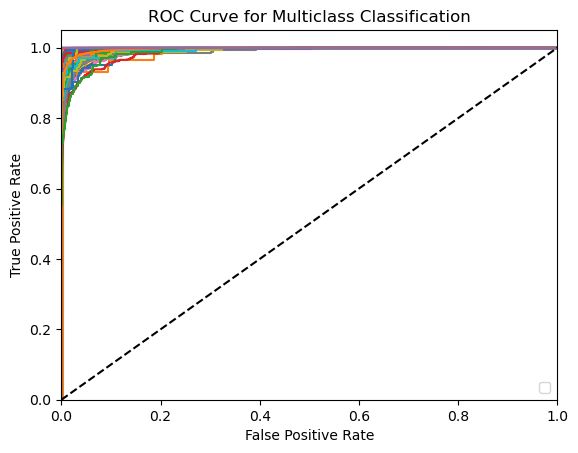

Accuracy 0.897
Precision 0.924
Recall 0.839
F1-Score 0.872
ROC-AUC 0.996


In [61]:
# Retrieve the best hyperparameters
best_params = study.best_params

# Train the model using the best parameters
best_model = XGBClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'Hyper_pramater_XGBClassifier.pkl')

# Evaluate the model on the test set
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, best_model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)


In [ ]:
##################### randomforest hyperparameter ################################

In [64]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the objective function
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Initialize the model with the parameters
    rf = RandomForestClassifier(random_state=42, **params)
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Evaluate accuracy on validation data
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_model = RandomForestClassifier(random_state=42, **study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Test Accuracy with Best Model:", accuracy_score(y_test, y_pred))
joblib.dump(best_model, 'Hyper_pramater_RandomForestClassifier.pkl')
# Metrics
# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, best_model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

[I 2025-01-23 18:15:19,293] A new study created in memory with name: no-name-b5436f51-da83-49bb-ad1f-e2f0b544ad4d
[I 2025-01-23 18:25:07,888] Trial 0 finished with value: 0.3565933606488837 and parameters: {'n_estimators': 994, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 0 with value: 0.3565933606488837.
[I 2025-01-23 18:29:19,667] Trial 1 finished with value: 0.4447696295676896 and parameters: {'n_estimators': 174, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.4447696295676896.
[I 2025-01-23 18:45:59,762] Trial 2 finished with value: 0.44482537558881735 and parameters: {'n_estimators': 928, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 2 with value: 0.44482537558881735.
[I 2025-01-23 18:58:25,512] Trial 3 finished with value: 0.614530200406946 and parameters: {'n_estimators': 268, 'max_depth': 29, 'min_samples_

KeyboardInterrupt: 

In [53]:
####################### Program for feature selection ##############################
# Combine all chunks into a single sparse matrix
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
X_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5688699 stored elements and shape (358767, 946)>

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.feature_selection import SelectFromModel

# df = df.drop(columns='Descrição_Carga')

# Sample a subset for feature selection
sample_df, X_test_sample, y_sample, y_test_sample = train_test_split(X_sparse, y, test_size=0.9, random_state=42, stratify=y)

# Step 2: Feature Selection with SelectKBest
k = 500  # Number of features to select
# Feature selection using Decision Tree
feature_selector = SelectFromModel(DecisionTreeClassifier(random_state=42), max_features=100)
feature_selector.fit(sample_df, y_sample)
important_features = feature_selector.get_support(indices=True)
X_selected = X_sparse[:, important_features]

In [43]:
# Apply SelectKBest with f_classif as the scoring function
k = 100  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_sparse, y)

# Get selected feature names and scores
selected_features = selector.get_support(indices=True)
scores = selector.scores_
X_selected1 = X_sparse[:, selected_features]
X_selected1



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2332673 stored elements and shape (358767, 100)>

In [ ]:
######### Top 20 features plot ################################## 

In [ ]:
# Sort features by importance
All_features = text_feature_names.tolist()+categorical_columns +numeric_columns

sorted_idx = np.argsort(important_features)[::-1]  # Indices of top features
top_20_idx = sorted_idx[:20]  # Get indices of top 20 features
top_20_importances = important_features[top_20_idx]  # Importance values
top_20_features = [f"Feature {i}" for i in top_20_idx]  # Feature names (can be customized)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_20_features, top_20_importances, color="skyblue")
plt.gca().invert_yaxis()  # Show most important feature at the top
plt.xlabel("Feature Importance")
plt.title("Top 20 Features by Importance")
plt.show()


In [37]:
X_selected, len(important_features)

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5011024 stored elements and shape (358767, 100)>,
 100)

In [ ]:
import scipy.sparse as sp
# Step 2: Extract the First 20 Rows and All Columns
first_20_rows = X_sparse[:important_features, :]
first_20_rows = sp.csr_matrix(first_20_rows)
y_first_20_rows = np.random.randint(0, 21, size=200)
first_20_rows

In [31]:
len(y)

358767

In [42]:
feature_selector = joblib.load('Feture_feature_selector.pkl')
important_features = joblib.load('Feture_important_features.pkl')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


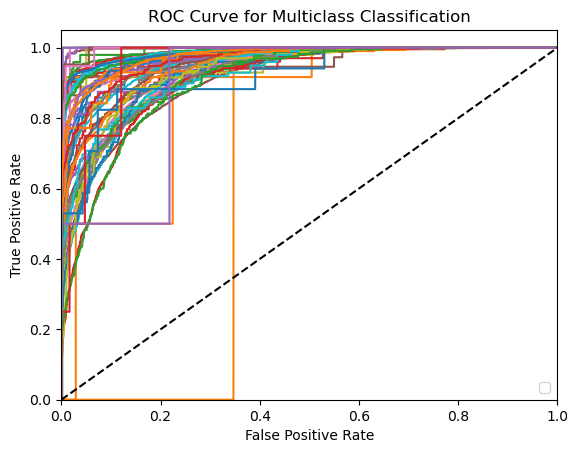

Accuracy 0.636
Precision 0.679
Recall 0.478
F1-Score 0.535
ROC-AUC 0.951


In [46]:
# Combine all chunks into a single sparse matrix
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
encoder = LabelEncoder()

# Fit and transform the data
y_encoder = encoder.fit_transform(y) 
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected1, y_encoder, test_size=0.2, random_state=42, stratify=y)

# Train a decision tree model
#clf = DecisionTreeClassifier(random_state=42)
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

#model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42)

#model = XGBClassifier(use_label_encoder=False, eval_metric=['mlogloss', 'merror'])
#model = DecisionTreeClassifier(random_state=42)
# Train the model and capture the history
#model.fit(X_train, y_train)#MLF_classifer_loss_acc(history)
#y_pred = model.predict(X_test)

#print(classification_report(y_test, y_pred))

# Logistic Regression 

from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

################### XGBClassifier with regularization ###################
# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the model with regularization parameters
model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    reg_lambda=1,  # L2 regularization
    reg_alpha=0.5,  # L1 regularization
    gamma=1,  # Minimum loss reduction
    objective='multi:softmax',
    num_class=3
)

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Load the model and preprocessing objects
joblib.dump(model, 'Feture_Regularization_XGBClassifier.pkl')


# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)


In [13]:
joblib.dump(model, 'Feature_catboot.pkl')

['Feature_catboot.pkl']

In [14]:
reming_months = ['D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\April.csv',
                 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\May.csv',
 
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\June.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\July.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Augest.csv',
    'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\September.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\October.csv',
    'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\November.csv',
    'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\December.csv',
 ]
reming_months

['D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\April.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\May.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\June.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\July.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\Augest.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\September.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\October.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\November.csv',
 'D:\\Averio\\NEXUS_project\\Dataset\\Test_Dataset_2024\\December.csv']

In [ ]:
############################### Test after feature selection ###############################

In [28]:
##########################    Ensemble Pre-Trained Models      ############################

In [45]:
import numpy as np
rf = joblib.load("Feture_RandomForestClassifier.pkl")
dt = joblib.load("Feture_DecisionTreeClassifier.pkl")
XGB = joblib.load("Feture_XGBClassifier.pkl")
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new, y_true_new, test_size=0.9, random_state=42, stratify=y_true_new)
# Predict probabilities with pre-trained models
rf_probs = rf.predict_proba(X_test1)  # Random Forest
xgb_probs = XGB.predict_proba(X_test1)  # XGBoost
dt_probs = dt.predict_proba(X_test1)  # Decision Tree

# Combine probabilities by averaging
ensemble_probs = (rf_probs + xgb_probs + dt_probs) / 3

# Final predictions: class with the highest probability
final_preds = np.argmax(ensemble_probs, axis=1)


In [70]:
from scipy.stats import mode

# Get predictions from pre-trained models
rf_preds = rf.predict(X_test1)
xgb_preds = xgb.predict(X_test1)
dt_preds = dt.predict(X_test1)

# Combine predictions using majority voting
final_preds, _ = mode(np.array([rf_preds, xgb_preds, dt_preds]), axis=0)
final_preds = final_preds.ravel()


In [82]:
# Assign weights to each model (e.g., based on validation accuracy)
rf_weight, xgb_weight, dt_weight = 0.6, 0.9, 0.3

# Weighted average of probabilities
ensemble_probs = (rf_probs * rf_weight + xgb_probs * xgb_weight + dt_probs * dt_weight) / (rf_weight + xgb_weight + dt_weight)
final_preds = np.argmax(ensemble_probs, axis=1)


In [83]:
if target_column in new_data.columns:
        y_true_new = y_test1 #target_label_encoder.transform(new_data[target_column].astype(str))
        y_pred_new = final_preds
        # Calculate metrics
        accuracy = accuracy_score(y_true_new, y_pred_new)
        print("Accuracy %.3f" % accuracy)
        


Accuracy 0.653


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import matplotlib.pyplot as plt

# Load your CSV file (replace 'your_file.csv' with the actual file path)
data = pd.read_csv(test_file, encoding="UTF-8", delimiter=",",on_bad_lines="skip", decimal=',')

# Assuming you have already fitted the vectorizer and encoder:
# - vectorizer: pre-fitted TfidfVectorizer
# - label_encoder: pre-fitted LabelEncoder

# Example pre-fitted vectorizer and label_encoder (replace with your actual objects)
vectorizer = tfidf_vectorizer  # This should be pre-fitted on training data
label_encoder = label_encoders  # This should be pre-fitted on training data

# 1. Transform the text column using TfidfVectorizer (you can replace 'text' with your column name)
X_tfidf = vectorizer.transform(data["text"])  # "text" is the column with textual data

# 2. Transform the label column using LabelEncoder (replace 'category' with the correct column name)
X_label = label_encoder.transform(data["category"])  # "category" is the column with labels
X_label = X_label.reshape(-1, 1)  # Convert to 2D array for consistency

# 3. Combine both sets of features (text + label-encoded)
combined_features = hstack([X_tfidf, X_label])

# 4. Extract feature names from both transformations
text_feature_names = vectorizer.get_feature_names_out()
category_feature_names = ["category_" + str(cls) for cls in label_encoder.classes_]

# Combine feature names
all_feature_names = list(text_feature_names) + category_feature_names

# If you want to visualize the top features by importance (if available in your model), you can do so:
# For now, we just show the number of features:
print(f"Total number of features: {len(all_feature_names)}")
print(f"First 5 feature names: {all_feature_names[:5]}")

# Optional: Visualize the top features (based on frequency or importance)
# Calculate feature frequency (sum of TF-IDF values for each feature)
feature_sums = combined_features.sum(axis=0).A1  # Sum the values for each feature
sorted_indices = np.argsort(feature_sums)[-20:][::-1]  # Get indices of top 20 features

# Extract the top 20 feature names and their corresponding frequencies
top_20_features = [all_feature_names[i] for i in sorted_indices]
top_20_frequencies = feature_sums[sorted_indices]

# Plot the top 20 features by frequency
plt.figure(figsize=(12, 6))
plt.bar(top_20_features, top_20_frequencies, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Names")
plt.ylabel("Frequency")
plt.title("Top 20 Features by Frequency (TF-IDF + Label Encoded)")
plt.tight_layout()
plt.show()


In [ ]:
#### To arrange results as table

In [74]:
rlf = joblib.load("XGBClassifier.pkl")
y_pred = rlf.predict(X_test)
# Generate the classification report
report = classification_report(y_test, y_pred)

# Print a tab-separated version
print("Class\tPrecision\tRecall\tF1-Score\tSupport")
for line in report.split('\n')[2:-3]:
    row = "\t".join(line.split())
    print(row)

Class	Precision	Recall	F1-Score	Support
0	0.98	0.94	0.96	186
1	1.00	0.50	0.67	2
2	1.00	1.00	1.00	1
3	0.96	0.94	0.95	949
4	0.95	0.82	0.88	139
5	0.96	0.98	0.97	423
6	0.94	0.88	0.91	1233
7	0.95	0.95	0.95	527
8	1.00	1.00	1.00	9
9	0.96	0.93	0.94	1066
10	0.87	0.86	0.86	141
11	1.00	0.92	0.96	12
12	1.00	0.96	0.98	49
13	0.97	0.89	0.93	238
14	0.97	0.96	0.97	119
15	0.97	0.86	0.91	37
16	1.00	0.25	0.40	4
17	0.83	0.85	0.84	2593
18	0.89	0.85	0.87	1399
19	0.89	0.91	0.90	7730
20	0.94	0.91	0.93	942
21	0.94	0.87	0.90	2191
22	0.97	0.93	0.95	1442
23	0.98	0.93	0.95	1283
24	0.92	0.84	0.88	726
25	0.69	0.84	0.76	7440
26	0.71	0.83	0.77	6237
27	0.92	0.90	0.91	2713
28	0.82	0.69	0.75	1748
29	0.87	0.90	0.89	1358
30	0.97	0.90	0.93	154
31	0.00	0.00	0.00	1
32	0.91	0.86	0.89	396
33	0.75	0.64	0.69	101
34	0.90	0.81	0.85	32
35	0.84	0.74	0.79	963
36	0.75	0.67	0.71	1156
37	0.79	0.58	0.67	261
38	0.74	0.64	0.69	775
39	0.85	0.84	0.84	5838
40	0.93	0.92	0.93	2236
41	0.98	0.77	0.86	57
42	0.83	0.72	0.77	1759
43	0.94	0.80	0.87	271


In [ ]:
############## SMOTE for oversampling minority classes and class weights in XGBoost 
########to handle the class imbalance in a multi-class classification problem.

[0]	validation_0-mlogloss:2.43842
[1]	validation_0-mlogloss:1.98799
[2]	validation_0-mlogloss:1.78610
[3]	validation_0-mlogloss:1.63310
[4]	validation_0-mlogloss:1.51764
[5]	validation_0-mlogloss:1.42827
[6]	validation_0-mlogloss:1.35085
[7]	validation_0-mlogloss:1.28340
[8]	validation_0-mlogloss:1.22849
[9]	validation_0-mlogloss:1.17961
[10]	validation_0-mlogloss:1.13747
[11]	validation_0-mlogloss:1.09908
[12]	validation_0-mlogloss:1.06535
[13]	validation_0-mlogloss:1.03511
[14]	validation_0-mlogloss:1.00856
[15]	validation_0-mlogloss:0.98406
[16]	validation_0-mlogloss:0.96282
[17]	validation_0-mlogloss:0.94373
[18]	validation_0-mlogloss:0.92490
[19]	validation_0-mlogloss:0.90459
[20]	validation_0-mlogloss:0.88784
[21]	validation_0-mlogloss:0.87353
[22]	validation_0-mlogloss:0.85867
[23]	validation_0-mlogloss:0.84587
[24]	validation_0-mlogloss:0.83310
[25]	validation_0-mlogloss:0.82071
[26]	validation_0-mlogloss:0.81067
[27]	validation_0-mlogloss:0.80019
[28]	validation_0-mlogloss:0.7

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


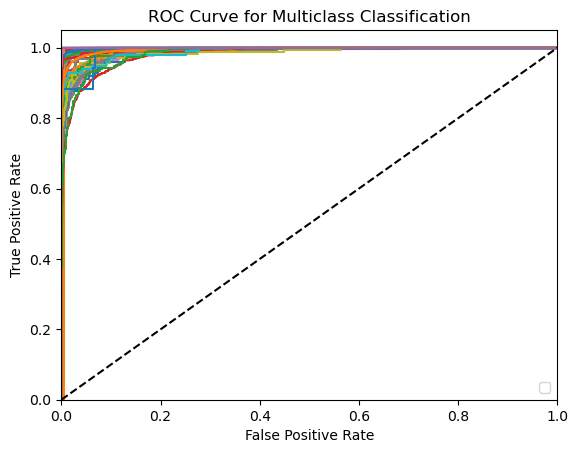

Accuracy 0.880
Precision 0.874
Recall 0.811
F1-Score 0.836
ROC-AUC 0.995


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import numpy as np
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)
# Example dataset (replace X and y with your data)
# X: Feature matrix
# y: Target labels (multi-class)
X_train, X_val, y_train, y_val = train_test_split(X_sparse, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Compute class weights for the resampled data
classes = np.unique(y_resampled)
class_weights = compute_class_weight('balanced', classes=classes, y=y_resampled)

# Map weights to each sample in the training set
weights = np.array([class_weights[label] for label in y_resampled])

# Step 3: Train XGBoost with sample weights
model = XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if probabilities are needed
    eval_metric='mlogloss',    # Evaluation metric
    random_state=42, 
    max_depth= 10, 
    learning_rate= 0.1881186603053861, 
    n_estimators= 170, 
subsample= 0.9277389356354614, 
colsample_bytree = 0.9397123327729827
)

model.fit(
    X_resampled, y_resampled,
    sample_weight=weights,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10
)

# Step 4: Make predictions and evaluate
y_pred = model.predict(X_val)

# Evaluate using metrics like F1-score, precision, recall, etc.
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
joblib.dump(model, 'SMOTE_XGBClassifier.pkl')

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_val, model, y_val)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)

In [86]:
############## Code Example with ADASYN "ADASYN (Adaptive Synthetic Sampling) is a technique used to 
#"handle class imbalance in datasets by generating synthetic data points for the minority class. 
#It is particularly helpful when the class distribution is highly skewed, and some classes are difficult to 
#learn due to their underrepresentation"

In [ ]:
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

# Split your dataset into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define sampling strategy dynamically
class_distribution = Counter(y_train)
max_class_size = max(class_distribution.values())
sampling_strategy = {cls: max_class_size for cls in class_distribution.keys()}

# Apply ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=2, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

print("Class distribution after ADASYN:", Counter(y_resampled))

print("ADASYN done")
# Train an XGBoost classifier on the resampled data
model = XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if probabilities are needed
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


In [98]:
# Train an XGBoost classifier on the resampled data
model = XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if probabilities are needed
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

joblib.dump(model, 'ADASYN_XGBClassifier.pkl')


              precision    recall  f1-score   support

           0       0.34      0.78      0.48       186
           1       0.00      0.00      0.00         2
           2       0.00      1.00      0.01         1
           3       0.40      0.55      0.47       949
           4       0.07      0.57      0.12       139
           5       0.51      0.76      0.61       423
           6       0.58      0.61      0.60      1233
           7       0.05      0.61      0.09       527
           8       0.03      0.67      0.05         9
           9       0.18      0.25      0.21      1066
          10       0.17      0.72      0.27       141
          11       0.05      0.58      0.09        12
          12       0.05      0.65      0.09        49
          13       0.34      0.68      0.46       238
          14       0.17      0.74      0.28       119
          15       0.05      0.46      0.08        37
          16       0.00      0.00      0.00         4
          17       0.44    

['ADASYN_XGBClassifier.pkl']

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, RandomOverSampler
from collections import Counter

# Check class distribution
print("Class distribution before resampling:", Counter(y_train))

# Define a fallback strategy for extremely small classes
ros = RandomOverSampler(random_state=42, sampling_strategy={cls: 5 for cls, count in Counter(y_train).items() if count < 5})

# Dynamically balance the rest with ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=2, sampling_strategy='auto')

# Combine RandomOverSampler and ADASYN
pipeline = Pipeline([
    ('random_oversampler', ros),
    ('adasyn', adasyn)
])

# Resample the dataset
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Verify the new class distribution
print("Class distribution after resampling:", Counter(y_resampled))


In [116]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_sparse, y, test_size=0.2, random_state=42, stratify=y)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 65,
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'seed': 42
}

# Train with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=evals,
    verbose_eval=True
)

# Predict and evaluate
y_pred = bst.predict(xgb.DMatrix(X_val))
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
print(classification_report(y_val, y_pred_classes))


[0]	train-mlogloss:3.08632	eval-mlogloss:3.08318
[1]	train-mlogloss:2.77970	eval-mlogloss:2.78362
[2]	train-mlogloss:2.59293	eval-mlogloss:2.60116
[3]	train-mlogloss:2.43986	eval-mlogloss:2.45139
[4]	train-mlogloss:2.30826	eval-mlogloss:2.32192
[5]	train-mlogloss:2.20041	eval-mlogloss:2.21695
[6]	train-mlogloss:2.10644	eval-mlogloss:2.12570
[7]	train-mlogloss:2.02240	eval-mlogloss:2.04423
[8]	train-mlogloss:1.94832	eval-mlogloss:1.97259
[9]	train-mlogloss:1.87826	eval-mlogloss:1.90474
[10]	train-mlogloss:1.81742	eval-mlogloss:1.84576
[11]	train-mlogloss:1.76011	eval-mlogloss:1.79017
[12]	train-mlogloss:1.70868	eval-mlogloss:1.74033
[13]	train-mlogloss:1.66127	eval-mlogloss:1.69451
[14]	train-mlogloss:1.61731	eval-mlogloss:1.65240
[15]	train-mlogloss:1.57552	eval-mlogloss:1.61234
[16]	train-mlogloss:1.53672	eval-mlogloss:1.57459
[17]	train-mlogloss:1.50204	eval-mlogloss:1.54109
[18]	train-mlogloss:1.47024	eval-mlogloss:1.51079
[19]	train-mlogloss:1.43906	eval-mlogloss:1.48081
[20]	train

In [ ]:
############ b. Stacking
#Train multiple classifiers and use their predictions as input features for a meta-classifier.
#This combines the strengths of different models

In [137]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
base_classifiers = [
    ('rf', DecisionTreeClassifier(max_depth=30, random_state=42) ),
    ('xgb', XGBClassifier(
    objective='multi:softprob',  # Multi-class classification
   #objective="multi:softmax",  # Use "multi:softprob" if you want probabilities instead of class labels
    num_class=65,  # Number of classes
    eval_metric="mlogloss",  # Multi-class log loss
    alpha=0.1,   # L1 regularization (increase for feature selection)
    lambda_=1.0, # L2 regularization (increase to reduce overfitting)
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,  # Helps prevent overfitting
    colsample_bytree=0.8,  # Feature selection per tree
    random_state=42
))
]

# Meta-classifier
meta_clf = RandomForestClassifier(n_estimators=50, max_depth=60, class_weight='balanced', random_state=42)
print()
# Create a stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_clf,
    passthrough=True  # Pass original features to the meta-classifier
)
print("done")
# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)
print("traing done")
# Evaluate the stacking classifier
y_pred = stacking_clf.predict(X_val)
print(classification_report(y_val, y_pred))
joblib.dump(stacking_clf, 'stacking_random_LogisticRegression_XGBOOST.pkl')


done
traing done
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       186
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.98      0.95      0.96       949
           4       0.89      0.90      0.90       139
           5       0.97      0.97      0.97       423
           6       0.96      0.89      0.93      1233
           7       0.96      0.96      0.96       527
           8       1.00      1.00      1.00         9
           9       0.96      0.93      0.95      1066
          10       0.86      0.93      0.89       141
          11       1.00      0.92      0.96        12
          12       0.98      0.98      0.98        49
          13       0.93      0.89      0.91       238
          14       0.97      0.94      0.96       119
          15       0.91      0.86      0.89        37
          16       1.00      0.25      0.40         4
         

['stacking_random_LogisticRegression_XGBOOST.pkl']

In [ ]:
#### code to opt different classifier

In [15]:
# Combine all chunks into a single sparse matrix
X_sparse = vstack(X_chunks)
y = np.concatenate(y_chunks)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42, stratify=y)

# Train a decision tree model
#clf = DecisionTreeClassifier(random_state=42)
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

#clf = RandomForestClassifier(max_depth=60)
############ XGBClassifier #################################################
# Step 4: Train the XGBClassifier
#xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric=['mlogloss', 'merror'])

eval_set = [(X_train, y_train), (X_test, y_test)]

#xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)
# Step 4: Evaluate the Classifier
#y_pred = xgb_clf.predict(X_test)
#print("\nClassifier: XGBoost")
#clf = trining_loss_plot(xgb_clf)
#clf.fit(X_train, y_train)

# Initialize the LGBMClassifier
# Initialize the LGBMClassifier with verbose parameter in params
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'verbose': -1
}
#model = LGBMClassifier(**params)

# Train the model with evaluation set
#model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='multi_logloss')

#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))
#clf = LGBMClassifier_trining_loss_plot(model)

# Initialize the MLPClassifier
# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the MLP model
model = Sequential()
model.add(Dense(100, input_dim=X_sparse.shape[1], activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and capture the history
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), verbose=0)

model = DecisionTreeClassifier(random_state=42)
#MLF_classifer_loss_acc(history)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Predict the classes for the test set
y_test_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_test_pred_prob, axis=1)
# Convert one-hot encoded y_test back to original labels
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

# Logistic Regression 

joblib.dump(model, 'DecisionTreeClassifier.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(target_label_encoder, 'target_label_encoder.pkl')

# Evaluate the model
# Evaluate the model
#y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ROC curve and AUC
#fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=target_label_encoder.transform(['positive_label'])[0])
#roc_auc = auc(fpr, tpr)
roc_auc = train_auca_roca_fun(X_test, model, y_test)
print("Accuracy %.3f" % accuracy)
print("Precision %.3f" % precision)
print("Recall %.3f" % recall)
print("F1-Score %.3f" % f1)
print("ROC-AUC %.3f" % roc_auc)


C:\Users\u236236\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       186
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.95      0.94      0.94       949
           4       0.85      0.76      0.81       139
           5       0.94      0.95      0.95       423
           6       0.93      0.93      0.93      1233
           7       0.94      0.95      0.95       527
           8       1.00      1.00      1.00         9
           9       0.93      0.94      0.93      1066
          10       0.76      0.82      0.79       141
          11       1.00      1.00      1.00        12
          12       0.86      0.86      0.86        49
          13       0.89      0.82      0.86       238
          14       0.86      0.95      0.90       119
          15       0.94      0.89      0.92        37
          16       0.67      0.50      0.57         4
          17       0.91    

NameError: name 'clf' is not defined